In [1]:
import os
import glob
from pathlib import Path
import pickle
from collections import defaultdict
from tqdm import tqdm, trange
from pympler import asizeof
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
#import scienceplots
#plt.style.use("science")

from joblib import Parallel, delayed

import xarray as xr
import xsimlab as xs
import fastscape
from fastscape.models import basic_model
from fastscape.models import sediment_model
from orographic_precipitation.fastscape_ext import precip_model
import orographic_precipitation
import topotoolbox as ttb
import pyflwdir as pfd

import pyvista as py
import networkx as netx
from networkx.algorithms.tree.branchings import maximum_branching
import rasterio as rio
from rasterio.transform import from_origin
from rasterio.crs import CRS
from shapely.geometry import LineString, Point
from shapely.strtree import STRtree
import tempfile

import traceback
import matplotlib

In [2]:
def flow_analysis(dem_path, flood=False):
    dem = ttb.read_tif(dem_path)

    dem_FO = ttb.FlowObject(dem)

    dem_acc = dem_FO.flow_accumulation()

    dem_strms = ttb.StreamObject(dem_FO, threshold=25, units="m2").klargestconncomps(-1)

    dem_longest_river = dem_strms.klargestconncomps(1)

    dem_basins = dem_FO.drainagebasins()

    if flood:
        dem_graphflood = ttb.run_graphflood(dem)
        return {"DEM":dem, "Flow_Object":dem_FO, "Accumulation":dem_acc, "Streams":dem_strms, "Basins":dem_basins, "Flood": dem_graphflood}

    return {"DEM":dem, "Flow_Object":dem_FO, "Accumulation":dem_acc, "Streams":dem_strms, "Longest_Stream":dem_longest_river, "Basins":dem_basins}

In [3]:
class River_Network_Sim:
    def __init__(self, streams, shp=(101,201)):
        self.streams = streams
        self.shp = shp

    def get_substreams(self):
        self.substreams = {}
        
        labels = self.streams.conncomps()

        for label in labels:
            component_indices = self.streams.node_indices_where(labels == label)
            mask = np.zeros(self.shp, dtype=bool)
            mask[component_indices[0], component_indices[1]] = True
            self.substreams[label] = self.streams.subgraph(mask)

    def coords2graph(self, visualize=False):
        
        self.graphs = {}

        for stream in self.substreams.keys():

            all_coords = self.substreams[stream].xy() 
            lines = [LineString(coords) for coords in all_coords]

            tree = STRtree(lines)
            line_map = {id(geom): i for i, geom in enumerate(lines)}

            G = netx.DiGraph()
            for line in lines:
                coords = list(line.coords)
                for u, v in zip(coords[:-1], coords[1:]):
                    G.add_edge(u, v)

            tolerance = 1e-6
            for line in lines:
                for endpoint in [Point(line.coords[0]), Point(line.coords[-1])]:
                    candidate_indices = tree.query(endpoint.buffer(tolerance), predicate='intersects')
                    for idx in candidate_indices:
                        target = tree.geometries[idx]
                        if target.equals(line):
                            continue
                        if target.distance(endpoint) < tolerance:
                            coords = list(target.coords)
                            for i in range(len(coords) - 1):
                                seg_start = Point(coords[i])
                                seg_end = Point(coords[i + 1])
                                segment = LineString([seg_start, seg_end])
                                if segment.distance(endpoint) < tolerance:
                                    u = tuple(endpoint.coords[0])
                                    snapped = segment.interpolate(segment.project(endpoint)).coords[0]
                                    if not G.has_edge(seg_start.coords[0], snapped):
                                        G.add_edge(seg_start.coords[0], snapped)
                                    if not G.has_edge(snapped, seg_end.coords[0]):
                                        G.add_edge(snapped, seg_end.coords[0])
                                    if not G.has_edge(u, snapped):
                                        G.add_edge(u, snapped)


            try:
                cycles = list(netx.simple_cycles(G))
                for cycle in cycles:
                    for i in range(len(cycle)):
                        u, v = cycle[i], cycle[(i + 1) % len(cycle)]
                        if G.has_edge(u, v):
                            G.remove_edge(u, v)
                            break  
            except Exception as e:
                print("Error checking cycles:", e)

            self.graphs[stream] = G

        if visualize:
            fig, ax = plt.subplots(figsize=(12, 6))

            graph_sizes = {k: self.graphs[k].number_of_nodes() for k in self.graphs}
            sizes = list(graph_sizes.values())
            cmap = cm.viridis
            norm = mcolors.Normalize(vmin=min(sizes), vmax=max(sizes))

            for k, G in self.graphs.items():
                color = cmap(norm(graph_sizes[k]))
                pos = {n: n for n in G.nodes}
                netx.draw(G, pos, ax=ax, node_size=5, arrows=True, edge_color=color, node_color=color)

            sm = cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array(sizes)
            cbar = fig.colorbar(sm, ax=ax, orientation='vertical', label='Number of Nodes')
            plt.title("Subgraphs colored by size (node count)")
            plt.show()
        
        return self.graphs


    def compute_outlets(self, dem=None, centre=None):
        outlet_directions = {}

        if centre is not None:
            mid_x = centre / 200
        elif dem is not None:
            mean_elev_per_x = np.mean(dem, axis=0)   
            max_ind = np.argmax(mean_elev_per_x)     
            mid_x = list(range(500000, 500000 + self.shp[1], 1))[max_ind]            
        else:
            all_x = [x for g in self.graphs.values() for x, y in g.nodes]
            min_x = min(all_x)
            max_x = max(all_x)
            mid_x = (min_x + max_x) / 2

        for k, g in self.graphs.items():
            if not netx.is_directed_acyclic_graph(g):
                print(f"Graph {k}: Not a DAG. May have cycles or multiple outlets.")

            sink_nodes = [n for n in g.nodes if g.out_degree(n) == 0]
            if len(sink_nodes) != 1:
                print(f"Graph {k}: Found {len(sink_nodes)} sink nodes. Taking the first.")

            outlet = sink_nodes[0]
            x, y = outlet

            outlet_directions[k] = "W" if x < mid_x else "E"

        self.outlet_directions = outlet_directions
        return outlet_directions


    def compute_metrics(self, metric_list=None):

        all_metrics = ['diameter', 'avg_path_len', 'longest_path', 'num_nodes', 
                       'num_edges', 'num_sources', 'num_sinks', 'radius',
                       'laplacian_spectrum', 'adjecency_spectrum', 'algebraic_connectivity',
                       'num_connected_components', 'spectral_radius', 'spectral_energy',
                       'spectral_gap', 'degree', 'degree_centrality', 'betweenness_centrality'
                       'closeness_centrality', 'pagerank', 'eigenvector', 'eccentricity',
                       'katz_centrality', 'laplacian_centrality']
        if metric_list is None:
            metric_list = all_metrics

        metrics = {}

        metrics["g_metrics"] = {
            'diameter' : {},
            'avg_path_len' : {},
            'longest_path' : {},
            'num_nodes' : {},
            'num_edges' : {},
            'num_sources' : {},
            'num_sinks' : {},
            'radius' : {},
            'laplacian_spectrum' : {},
            'adjecency_spectrum' : {},
            'algebraic_connectivity': {},
            'num_connected_components': {},
            'spectral_radius': {},
            'spectral_energy': {},
            'spectral_gap': {},
        }
        metrics["n_metrics"] = {
            'degree' : {},
            'degree_centrality': {},
            'betweenness_centrality' : {},
            'closeness_centrality' : {},
            'pagerank' : {},
            'eigenvector' : {},
            'eccentricity' : {},
            'katz_centrality' : {},
            'laplacian_centrality' : {},
        }

        for k, G in self.graphs.items():
            if "num_nodes" in metric_list:
                metrics["g_metrics"]['num_nodes'][k] = G.number_of_nodes()
            if "num_edges" in metric_list:
                metrics["g_metrics"]['num_edges'][k] = G.number_of_edges()
            if "num_sources" in metric_list:
                metrics["g_metrics"]['num_sources'][k] = len([n for n in G.nodes if G.in_degree(n) == 0])
            if "num_sinks" in metric_list:
                metrics["g_metrics"]['num_sinks'][k] = sum(1 for n in G.nodes if G.out_degree(n) == 0)

            if "longest_path" in metric_list:
                if netx.is_directed_acyclic_graph(G):
                    metrics["g_metrics"]['longest_path'][k] = len(netx.dag_longest_path(G))

            #### Node Metrics ####
            if "degree" in metric_list:
                metrics["n_metrics"]['degree'][k] = dict(netx.degree(G))
            if "degree_centrality" in metric_list:
                metrics["n_metrics"]['degree_centrality'][k] = netx.degree_centrality(G)
            if "betweenness_centrality" in metric_list:
                metrics["n_metrics"]['betweenness_centrality'][k] = netx.betweenness_centrality(G)
            if "closeness_centrality" in metric_list:
                metrics["n_metrics"]['closeness_centrality'][k] = netx.closeness_centrality(G)
            if "pagerank" in metric_list:
                metrics["n_metrics"]['pagerank'][k] = netx.pagerank(G, alpha=0.85)
            if "katz_centrality" in metric_list:
                metrics["n_metrics"]['katz_centrality'][k] = netx.katz_centrality(G)
            if "laplacian_centrality" in metric_list:
                metrics["n_metrics"]['laplacian_centrality'][k] = netx.laplacian_centrality(G)


            #### Undirected Metrics ####
            Gu = G.to_undirected()
            if "diameter" in metric_list:
                metrics["g_metrics"]['diameter'][k] = netx.diameter(Gu)
            if "avg_path_len" in metric_list:
                metrics["g_metrics"]['avg_path_len'][k] = netx.average_shortest_path_length(Gu)
            if "radius" in metric_list:
                metrics["g_metrics"]['radius'][k] = netx.radius(Gu)
            if "eccentricity" in metric_list:
                metrics["n_metrics"]['eccentricity'][k] = netx.eccentricity(Gu)

            if "eigenvector" in metric_list:
                try:
                    metrics["n_metrics"]['eigenvector'][k] = netx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)
                except netx.PowerIterationFailedConvergence:
                    metrics["n_metrics"]['eigenvector'][k] = {}
                except Exception:
                    metrics["n_metrics"]['eigenvector'][k] = {}


            try:
                Gu = G.to_undirected()
                lap_spec = np.array(netx.laplacian_spectrum(Gu))
                A = netx.to_numpy_array(Gu, weight=None, dtype=float)   
                adj_spec = np.linalg.eigvals(A)
                
                if "laplacian_spectrum" in metric_list:
                    metrics["g_metrics"]['laplacian_spectrum'][k] = lap_spec
                if "adjecency_spectrum" in metric_list:
                    metrics["g_metrics"]['adjecency_spectrum'][k] = adj_spec

                lap_spec_sorted = np.sort(lap_spec)
                if "algebraic_connectivity" in metric_list:
                    if len(lap_spec_sorted) > 1:
                        metrics["g_metrics"]['algebraic_connectivity'][k] = lap_spec_sorted[1]
                    else:
                        metrics["g_metrics"]['algebraic_connectivity'][k] = 0
                
                if "num_connected_components" in metric_list:
                    num_zeros = np.sum(np.isclose(lap_spec_sorted, 0))
                    metrics["g_metrics"]['num_connected_components'][k] = int(num_zeros)

                adj_spec_abs_sorted = np.sort(np.abs(adj_spec))[::-1]  

                if "spectral_radius" in metric_list:
                    metrics["g_metrics"]['spectral_radius'][k] = adj_spec_abs_sorted[0] if len(adj_spec_abs_sorted) > 0 else 0
                if "spectral_energy" in metric_list:
                    metrics["g_metrics"]['spectral_energy'][k] = np.sum(np.abs(adj_spec))

                if "spectral_gap" in metric_list:
                    if len(adj_spec_abs_sorted) > 1:
                        spectral_gap = adj_spec_abs_sorted[0] - adj_spec_abs_sorted[1]
                    else:
                        spectral_gap = 0
                    metrics["g_metrics"]['spectral_gap'][k] = spectral_gap

            except Exception as e:
                print(f"Spectral metrics failed for graph {k}: {e}")
        return metrics

In [4]:
def parallel_metrics(k, run, metrics=None, ny=100, nx=200, centre=None):
    dem = run.topography__elevation.isel(time=-1).to_numpy()

    x_min = 500000.0
    y_max = 4600000.0
    pixel_size = 1.0
    transform = from_origin(x_min, y_max, pixel_size, pixel_size)
    crs = CRS.from_epsg(32633)

    # Create a private temp dir for this worker; it is removed automatically
    with tempfile.TemporaryDirectory(prefix=f"sim_tmp_{k}_") as tmpdir:
        out_fp = Path(tmpdir) / "output.tif"   # name local to this dir; no collisions

        # write the raster and close it
        with rio.open(
            str(out_fp),
            'w',
            driver='GTiff',
            height=dem.shape[0],
            width=dem.shape[1],
            count=1,
            dtype=dem.dtype,
            crs=crs,
            transform=transform
        ) as dst:
            dst.write(dem, 1)

        # call the 3rd-party function with the unique path
        ttb_dict = flow_analysis(str(out_fp), flood=False)

        # build River_Network_Sim from ttb_dict
        RNS = River_Network_Sim(ttb_dict["Streams"], shp=(ny, nx))
        RNS.get_substreams()

        result = {
            "graphs": RNS.coords2graph(visualize=False),
            "outlets": RNS.compute_outlets(dem=dem, centre=centre),
            "metrics": RNS.compute_metrics(metric_list=metrics),
        }

    # tempdir and output.tif removed here
    return result


def build_results_list_from_nc(path, fn, limit=None):
    """
    Returns a list of xarray Datasets for a given field index `fn`.
    """
    path = Path(path)
    files = sorted(path.glob(f"field_{fn}_*.nc"))

    if limit is not None:
        files = files[:limit]

    datasets = [xr.open_dataset(p) for p in files]
    return datasets

class SIM_Bundler:
    def __init__(self, ny, nx, results_list=None, results_path=None, fn=None, limit=None):
        self.ny=ny
        self.nx=nx
        if (results_list == None) & (results_path != None):
            self.results_list = build_results_list_from_nc(path=results_path, fn=fn, limit=limit)
        else:
            self.results_list = results_list

    def fastscape2graphs(self, parallel=False, specific_run='all', metrics=None, centre=None):
        if specific_run == 'all':
            specific_run = list(range(0,len(self.results_list), 1))

        self.runs = {}

        if parallel:
            result = Parallel(n_jobs=1)(delayed(parallel_metrics)(k, run, metrics=metrics, ny=self.ny, nx=self.nx, centre=centre) for k, run in enumerate(self.results_list))
            for run, res in enumerate(result):
                self.runs[run] = res
        else:

            for run in tqdm(specific_run):
                dem = self.results_list[run].topography__elevation.isel(time=-1).to_numpy()

                x_min = 500000.0  
                y_max = 4600000.0  
                pixel_size = 1.0

                transform = from_origin(x_min, y_max, pixel_size, pixel_size)

                crs = CRS.from_epsg(32633)

                with rio.open(
                    'output.tif',
                    'w',
                    driver='GTiff',
                    height=dem.shape[0],
                    width=dem.shape[1],
                    count=1,
                    dtype=dem.dtype,
                    crs=crs,
                    transform=transform
                ) as dst:
                    dst.write(dem, 1)

                ttb_dict = flow_analysis('output.tif', flood=False)

                RNS = River_Network_Sim(ttb_dict["Streams"])
                RNS.get_substreams()

                self.runs[run] = {
                    "graphs" : RNS.coords2graph(visualize=False),
                    "outlets" : RNS.compute_outlets(dem=dem, centre=centre),
                    "metrics" : RNS.compute_metrics(metric_list=metrics),
                }

In [5]:
def metric_analysis(SIM, metric, node_based, visualize=True, log=False, bin_num=100, annotation=None, show=True):
    param_west = []
    param_east = []

    if node_based:
        for run_key, run in SIM.runs.items():
            west_keys = [k for k in run["outlets"].keys() if run["outlets"][k] == "W"]
            east_keys = [k for k in run["outlets"].keys() if run["outlets"][k] == "E"]

            p_west = [
                val
                for k in run["metrics"]["n_metrics"][metric]
                if k in west_keys
                for val in run["metrics"]["n_metrics"][metric][k].values() if val is not None
            ]
            param_west.append(p_west)

            p_east = [
                val
                for k in run["metrics"]["n_metrics"][metric]
                if k in east_keys
                for val in run["metrics"]["n_metrics"][metric][k].values() if val is not None
            ]
            param_east.append(p_east)

    else:
        for run_key, run in SIM.runs.items():
            west_keys = [k for k in run["outlets"].keys() if run["outlets"][k] == "W"]
            east_keys = [k for k in run["outlets"].keys() if run["outlets"][k] == "E"]

            p_west = [run["metrics"]["g_metrics"][metric][k] 
                    for k in run["metrics"]["g_metrics"][metric] 
                    if k in west_keys and run["metrics"]["g_metrics"][metric][k] is not None]
            param_west.append(p_west)

            p_east = [run["metrics"]["g_metrics"][metric][k] 
                    for k in run["metrics"]["g_metrics"][metric] 
                    if k in east_keys and run["metrics"]["g_metrics"][metric][k] is not None]
            param_east.append(p_east)

    flat_west = [item for sublist in param_west for item in sublist]
    flat_east = [item for sublist in param_east for item in sublist]

    if visualize:
        fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(22, 6), sharey=True, sharex=True)

        maximum = max(max(flat_west), max(flat_east))
        minimum = min(min(flat_west), min(flat_east))

        bins = np.linspace(minimum, maximum, bin_num)

        ax[0].hist(flat_west, bins=bins, density=True, edgecolor="black")
        ax[0].set_title("West")

        ax[1].hist(flat_east, bins=bins, density=True, edgecolor="black")
        ax[1].set_title("East")

        if log:
            ax[0].set_yscale("log")
            ax[1].set_yscale("log")

        if annotation is not None:
            plt.suptitle(annotation["title"])
            plt.savefig(annotation["save_as"])

        if show:
            plt.show()
        plt.close()

    return {"W": flat_west, "E": flat_east}

In [6]:
class RandomFieldExperiment:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def generate_fields(self, centres, thicknesses, kfs, background_kf, path=r"F:\ESPM"):
        self.field_dict = {
            "fields": [],
            "centre": [],
            "thickness": [],
            "Kf": [],
            "dist2mean": []
        }

        counter = 0

        for c in centres:
            for tk in thicknesses:
                for kf in kfs:
                    kf_new = (
                        xr.where(
                            (self.x > c - tk/2) & (self.x < c + tk/2),
                            kf, background_kf
                        )
                    )

                    self.field_dict["fields"].append(kf_new)
                    self.field_dict["thickness"].append(tk)
                    self.field_dict["centre"].append(c)
                    self.field_dict["Kf"].append(kf)
                    self.field_dict["dist2mean"].append(
                        np.abs((len(self.x) / 2) - c)
                    )

                    counter += 1

        with open(Path(path) / "EXP1_field_dict.pkl", "wb") as f:
            pickle.dump(self.field_dict, f)

    def run_experiment(self, model, ds_in, n_noises, n_jobs=1, storage=None):
        self.results = {}
        self.noises = [np.random.random(self.x.shape) for i in range(0, n_noises)]

        if storage:
            os.makedirs(storage, exist_ok=True)

            def run_model_parallel(model, ds_in, x, y, noise, kf, i, j, storage):
                with model.drop_processes('init_topography'):
                    ds_out = ds_in.xsimlab.update_vars(
                        input_vars={
                            'topography__elevation': noise,
                            'spl__k_coef_bedrock': kf
                        }
                    ).xsimlab.run()

                path = f"{storage}/field_{i}_noise_{j}.nc"
                ds_out.drop_vars("border").to_netcdf(path)
                return path

            for i in trange(len(self.field_dict["fields"])):
                self.results[f"field_{i}"] = Parallel(n_jobs=n_jobs)(
                    delayed(run_model_parallel)(
                        model, ds_in, self.x, self.y,
                        noise=n, kf=self.field_dict["fields"][i], i=i, j=j, storage=storage) for j, n in enumerate(self.noises))

        else:
            def run_model_parallel(model, ds_in, x, y, noise, kf):
                with model.drop_processes('init_topography'):
                    ds_out = ds_in.xsimlab.update_vars(
                        input_vars={
                            'topography__elevation': noise,
                            'spl__k_coef_bedrock': kf
                        }
                    ).xsimlab.run()
                return ds_out

            for i in trange(len(self.field_dict["fields"])):
                self.results[i] = Parallel(n_jobs=n_jobs)(
                    delayed(run_model_parallel)(
                        model, ds_in, self.x, self.y,
                        noise=n, kf=self.field_dict["fields"][i]) for n in self.noises)

In [10]:
%load_ext xsimlab.ipython

In [11]:
from fastscape.processes import FlowAccumulator, DrainageArea
model = basic_model.update_processes({'drainage': FlowAccumulator})
model_sed = sediment_model.update_processes({'drainage': FlowAccumulator})

In [12]:
nx,ny = 201, 101
xl,yl = 40e3, 20e3
x,y = np.meshgrid(np.linspace(0,xl,nx), np.linspace(0,yl,ny))
tf = 10e7
tstep = xr.DataArray(np.linspace(0,tf,401), dims='tstep')
time = xr.DataArray(np.linspace(0,tf,21), dims='time')


precip_base_arr = np.ones([ny, nx])
precip_base_arr=precip_base_arr*5
xr_2d = xr.DataArray(np.ones((ny,nx)), dims=['y','x'])
precip_base_xr=xr_2d*5

noises = [np.random.random(x.shape) for i in range(0,1)]

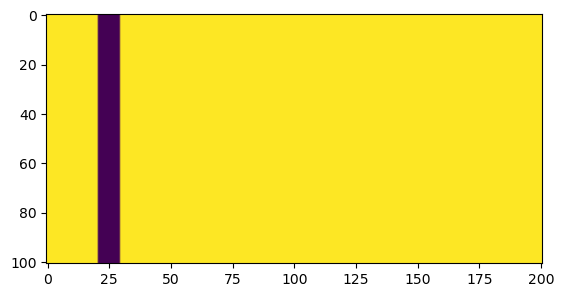

In [13]:
kf_new = xr.where((x-9.7e3)*(x-10.3e3)<0, 0.2e-5, 1e-5)

kf_new = (
                        xr.where(
                            (x < (x.max() / 2 - x.max() * 0.35)) & (x > (x.max() / 2 - x.max() * 0.4)),
                             0.2e-5, 1e-5
                        )
                    )

plt.imshow(kf_new)

# Sediment Tests

In [14]:
# %create_setup model_sed
ds_in_sed = xs.create_setup(
    model=model_sed,
    clocks={'tstep':tstep, 'time':time},
    master_clock='tstep',
    input_vars={
        'grid__shape': [ny, nx], 
        'grid__length': [yl, xl],  
        'boundary__status': ['fixed_value', 'fixed_value', 'looped', 'looped'],

        'uplift__rate': 1e-4,  # m/year = 0.1 mm/yr, typical for tectonic uplift

        'init_topography__seed': None,

        'flow__slope_exp': 1.0,  

        'drainage__runoff': precip_base_xr,  

        'spl__area_exp': 0.5,  
        'spl__slope_exp': 1.0,  
        'spl__tol_rel': 1e-4,  
        'spl__tol_abs': 1e-6,  
        'spl__max_iter': 500,  

        'spl__k_coef_bedrock': 5e-6,  # typical: 1e-7 to 1e-5 (m^0.1 / yr)
        'spl__k_coef_soil': 1e-4,     # soil is usually more erodible

        'spl__g_coef_bedrock': 0.0,   # no sediment transport in pure bedrock channels
        'spl__g_coef_soil': 0.3,      # nonzero for diffusive sediment transport

        'diffusion__diffusivity_bedrock': 0.0,  # bedrock creep is negligible
        'diffusion__diffusivity_soil': 0.01,    # m²/yr, typical 1e-3 to 1e-1
    },
    output_vars={
        'topography__elevation': 'time',
        'drainage__flowacc': 'time',
        'flow__basin': 'time',
    }
)


In [15]:
x,y = np.meshgrid(np.linspace(0, ds_in_sed.grid__length[1], ds_in_sed.grid__shape[1].values),
                  np.linspace(0, ds_in_sed.grid__length[0], ds_in_sed.grid__shape[0].values))

x = xr.DataArray(x, dims=('y', 'x'))
y = xr.DataArray(y, dims=('y', 'x'))

In [25]:
############### Test 1 ###############

EXP1 = RandomFieldExperiment(x=x, y=y)

EXP1.generate_fields(centres=[10000, 20000, 30000], thicknesses=[100, 1000, 5000],  kfs=np.logspace(-6, -4, 10), background_kf=1e-5)

EXP1.run_experiment(model=model_sed, ds_in=ds_in_sed, n_noises=100, n_jobs=-4, storage=r"F:\ESPM")

100%|██████████| 90/90 [3:08:20<00:00, 125.56s/it]  


In [36]:
############### Test 2 ###############

EXP1 = RandomFieldExperiment(x=x, y=y)

EXP1.generate_fields(centres=[10000, 20000, 30000], thicknesses=[1000],  kfs=[0.1e-5, 0.5e-5], background_kf=1e-5)

EXP1.run_experiment(model=model_sed, ds_in=ds_in_sed, n_noises=10, n_jobs=-4, storage=r"F:\ESPM_Test")

100%|██████████| 6/6 [01:20<00:00, 13.34s/it]


In [16]:
p = r"E:\ESPM"

with open(Path(p) / "EXP1_field_dict.pkl", "rb") as f:
    EXP1_field_dict = pickle.load(f)

(array([17776.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  2525.]),
 array([1.0e-05, 1.9e-05, 2.8e-05, 3.7e-05, 4.6e-05, 5.5e-05, 6.4e-05,
        7.3e-05, 8.2e-05, 9.1e-05, 1.0e-04]),
 <BarContainer object of 10 artists>)

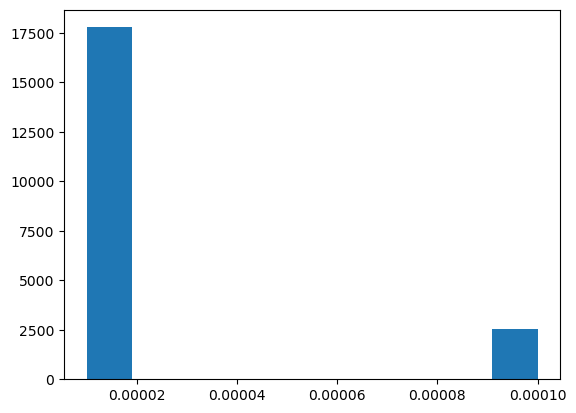

In [113]:
#print(asizeof.asizeof(EXP1) / (1024 ** 3))

plt.hist(EXP1_field_dict["fields"][-1].to_numpy().flatten())

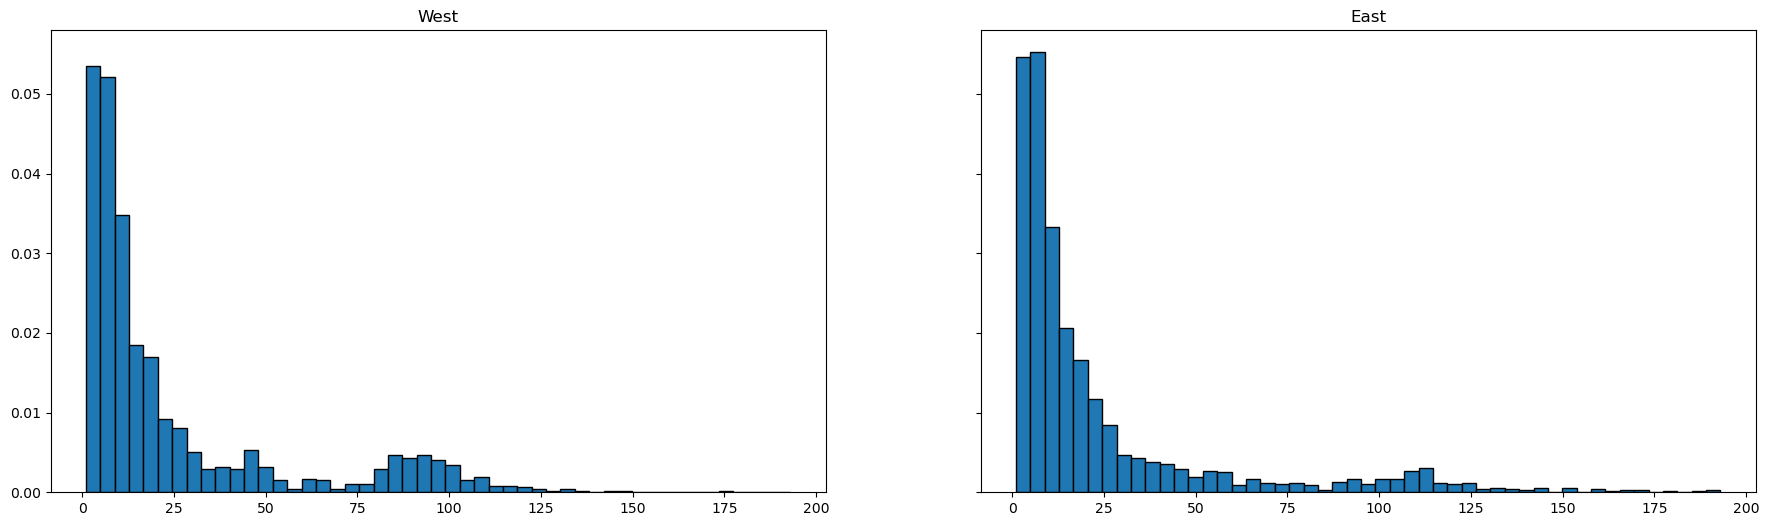

In [37]:
SIM_Sed_01_t = SIM_Bundler(ny=ny, nx=nx, results_path=p, fn=2, limit=None)
SIM_Sed_01_t.fastscape2graphs(parallel=True, metrics="diameter")
_ = metric_analysis(SIM=SIM_Sed_01_t, metric='diameter', node_based=False, visualize=True, log=False, bin_num=50)

In [17]:
def simulation_analysis(nx, ny, path, setup_dict, metric, node_based, log, save_as, bin_num=50, limit=None, show=False):
    centres = setup_dict["centre"]
    thicknesses = setup_dict["thickness"]
    kfs = setup_dict["Kf"]


    for i, (c, t, k) in enumerate(zip(centres, thicknesses, kfs)):
        print(f"Processing field {i} -> Centre: {c}, Thickness: {t}, KF: {k}")
        SIM = SIM_Bundler(ny=ny, nx=nx, results_path=path, fn=i, limit=limit)
        SIM.fastscape2graphs(parallel=True, metrics=metric)
        _ = metric_analysis(SIM=SIM, metric=metric, node_based=node_based, visualize=True, log=log, bin_num=bin_num, annotation={
            "title": f"Centre: {c}, Thickness: {t}, KF: {k}",
            "save_as": Path(save_as) / f"{metric}_{int(c)}_{int(t)}_{k:.3e}.png"
        }, show=show)

In [20]:
_ = simulation_analysis(nx, ny, r"F:\ESPM", setup_dict=EXP1_field_dict, 
                    metric="eccentricity", node_based=True, log=True, save_as=r"F:\ESPM", limit=None)

Processing field 0 -> Centre: 10000, Thickness: 1000, KF: 1e-06
Processing field 1 -> Centre: 10000, Thickness: 1000, KF: 2e-06
Processing field 2 -> Centre: 10000, Thickness: 1000, KF: 3e-06
Processing field 3 -> Centre: 10000, Thickness: 1000, KF: 4e-06
Processing field 4 -> Centre: 10000, Thickness: 1000, KF: 4.9999999999999996e-06
Processing field 5 -> Centre: 10000, Thickness: 1000, KF: 5.999999999999999e-06
Processing field 6 -> Centre: 10000, Thickness: 1000, KF: 7e-06
Processing field 7 -> Centre: 10000, Thickness: 1000, KF: 8e-06
Processing field 8 -> Centre: 10000, Thickness: 2500, KF: 1e-06
Processing field 9 -> Centre: 10000, Thickness: 2500, KF: 2e-06
Processing field 10 -> Centre: 10000, Thickness: 2500, KF: 3e-06
Processing field 11 -> Centre: 10000, Thickness: 2500, KF: 4e-06
Processing field 12 -> Centre: 10000, Thickness: 2500, KF: 4.9999999999999996e-06
Processing field 13 -> Centre: 10000, Thickness: 2500, KF: 5.999999999999999e-06
Processing field 14 -> Centre: 100

In [18]:
def _joblib_worker(i, centre, thickness, kf, nx, ny, path, metric, node_based,
                   log, save_as, bin_num, limit, show, SIM_Bundler_cls, metric_analysis_fn,
                   use_matplotlib_aggressively=True):
    try:
        if use_matplotlib_aggressively:
            matplotlib.use("Agg")

        print(f"[worker] Processing field {i} -> Centre: {centre}, Thickness: {thickness}, KF: {kf}")

        SIM = SIM_Bundler_cls(ny=ny, nx=nx, results_path=path, fn=i, limit=limit)
        # If inner is parallel, prefer outer threading or switch inner to parallel=False
        SIM.fastscape2graphs(parallel=True, metrics=metric)

        _ = metric_analysis_fn(
            SIM=SIM,
            metric=metric,
            node_based=node_based,
            visualize=True,
            log=log,
            bin_num=bin_num,
            annotation={
                "title": f"Centre: {centre}, Thickness: {thickness}, KF: {kf}",
                "save_as": Path(save_as) / f"{metric}_{int(centre)}_{int(thickness)}_{kf:.3e}.png"
            },
            show=show
        )
        return {"i": i, "status": "ok"}
    except Exception as e:
        return {"i": i, "status": "error", "error": str(e), "traceback": traceback.format_exc()}

def simulation_analysis_joblib_callable(nx, ny, path, setup_dict, metric, node_based, log, save_as,
                                        bin_num=50, limit=None, show=False, n_jobs=None, backend="loky",
                                        SIM_Bundler_cls=None, metric_analysis_fn=None, verbose=10):
    centres = setup_dict["centre"]
    thicknesses = setup_dict["thickness"]
    kfs = setup_dict["Kf"]

    save_as = Path(save_as)
    save_as.mkdir(parents=True, exist_ok=True)

    fields = list(enumerate(zip(centres, thicknesses, kfs)))
    if n_jobs is None:
        n_jobs = min(len(fields), os.cpu_count() or 1)

    if SIM_Bundler_cls is None or metric_analysis_fn is None:
        raise ValueError("You must pass SIM_Bundler_cls and metric_analysis_fn when running from a notebook.")

    print(f"Launching joblib.Parallel with backend={backend}, n_jobs={n_jobs}")
    results = Parallel(n_jobs=n_jobs, backend=backend, verbose=verbose)(
        delayed(_joblib_worker)(
            i, c, t, k, nx, ny, path, metric, node_based, log, str(save_as),
            bin_num, limit, show, SIM_Bundler_cls, metric_analysis_fn
        )
        for i, (c, t, k) in fields
    )

    results = sorted(results, key=lambda x: x.get("i", -1))
    oks = [r for r in results if r.get("status") == "ok"]
    errs = [r for r in results if r.get("status") == "error"]
    print(f"Completed: {len(oks)} OK, {len(errs)} ERROR")
    if errs:
        for r in errs[:5]:
            print(f"Field {r['i']}: {r['error']}")
            print(r['traceback'][:1000])
    return results

In [17]:
res = simulation_analysis_joblib_callable(
    nx, ny, r"F:\ESPM", setup_dict=EXP1_field_dict,
    metric='num_nodes', node_based=False, log=True, save_as=r"F:\ESPM",
    limit=None, n_jobs=-4, backend="loky", SIM_Bundler_cls=SIM_Bundler, metric_analysis_fn=metric_analysis, verbose=10
)
print(res)

Launching joblib.Parallel with backend=loky, n_jobs=-4


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 17 concurrent workers.


In [116]:
res = simulation_analysis_joblib_callable(
    nx, ny, r"F:\ESPM", setup_dict=EXP1_field_dict,
    metric='longest_path', node_based=False, log=True, save_as=r"F:\ESPM",
    limit=None, n_jobs=-4, backend="loky", SIM_Bundler_cls=SIM_Bundler, metric_analysis_fn=metric_analysis, verbose=10
)
print(res)

Launching joblib.Parallel with backend=loky, n_jobs=-4


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 17 concurrent workers.
[Parallel(n_jobs=-4)]: Done   7 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-4)]: Done  16 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-4)]: Done  27 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-4)]: Done  38 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-4)]: Done  51 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-4)]: Done  67 out of  90 | elapsed: 14.4min remaining:  4.9min
[Parallel(n_jobs=-4)]: Done  77 out of  90 | elapsed: 17.1min remaining:  2.9min
[Parallel(n_jobs=-4)]: Done  87 out of  90 | elapsed: 18.8min remaining:   38.9s


Completed: 90 OK, 0 ERROR
[{'i': 0, 'status': 'ok'}, {'i': 1, 'status': 'ok'}, {'i': 2, 'status': 'ok'}, {'i': 3, 'status': 'ok'}, {'i': 4, 'status': 'ok'}, {'i': 5, 'status': 'ok'}, {'i': 6, 'status': 'ok'}, {'i': 7, 'status': 'ok'}, {'i': 8, 'status': 'ok'}, {'i': 9, 'status': 'ok'}, {'i': 10, 'status': 'ok'}, {'i': 11, 'status': 'ok'}, {'i': 12, 'status': 'ok'}, {'i': 13, 'status': 'ok'}, {'i': 14, 'status': 'ok'}, {'i': 15, 'status': 'ok'}, {'i': 16, 'status': 'ok'}, {'i': 17, 'status': 'ok'}, {'i': 18, 'status': 'ok'}, {'i': 19, 'status': 'ok'}, {'i': 20, 'status': 'ok'}, {'i': 21, 'status': 'ok'}, {'i': 22, 'status': 'ok'}, {'i': 23, 'status': 'ok'}, {'i': 24, 'status': 'ok'}, {'i': 25, 'status': 'ok'}, {'i': 26, 'status': 'ok'}, {'i': 27, 'status': 'ok'}, {'i': 28, 'status': 'ok'}, {'i': 29, 'status': 'ok'}, {'i': 30, 'status': 'ok'}, {'i': 31, 'status': 'ok'}, {'i': 32, 'status': 'ok'}, {'i': 33, 'status': 'ok'}, {'i': 34, 'status': 'ok'}, {'i': 35, 'status': 'ok'}, {'i': 36, '

[Parallel(n_jobs=-4)]: Done  90 out of  90 | elapsed: 19.2min finished


In [117]:
res = simulation_analysis_joblib_callable(
    nx, ny, r"F:\ESPM", setup_dict=EXP1_field_dict,
    metric='diameter', node_based=False, log=True, save_as=r"F:\ESPM",
    limit=None, n_jobs=-4, backend="loky", SIM_Bundler_cls=SIM_Bundler, metric_analysis_fn=metric_analysis, verbose=10
)
print(res)

[Parallel(n_jobs=-4)]: Using backend LokyBackend with 17 concurrent workers.


Launching joblib.Parallel with backend=loky, n_jobs=-4


[Parallel(n_jobs=-4)]: Done   7 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-4)]: Done  16 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-4)]: Done  27 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-4)]: Done  38 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-4)]: Done  51 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-4)]: Done  67 out of  90 | elapsed: 18.5min remaining:  6.4min
[Parallel(n_jobs=-4)]: Done  77 out of  90 | elapsed: 21.7min remaining:  3.7min
[Parallel(n_jobs=-4)]: Done  87 out of  90 | elapsed: 23.9min remaining:   49.3s


Completed: 90 OK, 0 ERROR
[{'i': 0, 'status': 'ok'}, {'i': 1, 'status': 'ok'}, {'i': 2, 'status': 'ok'}, {'i': 3, 'status': 'ok'}, {'i': 4, 'status': 'ok'}, {'i': 5, 'status': 'ok'}, {'i': 6, 'status': 'ok'}, {'i': 7, 'status': 'ok'}, {'i': 8, 'status': 'ok'}, {'i': 9, 'status': 'ok'}, {'i': 10, 'status': 'ok'}, {'i': 11, 'status': 'ok'}, {'i': 12, 'status': 'ok'}, {'i': 13, 'status': 'ok'}, {'i': 14, 'status': 'ok'}, {'i': 15, 'status': 'ok'}, {'i': 16, 'status': 'ok'}, {'i': 17, 'status': 'ok'}, {'i': 18, 'status': 'ok'}, {'i': 19, 'status': 'ok'}, {'i': 20, 'status': 'ok'}, {'i': 21, 'status': 'ok'}, {'i': 22, 'status': 'ok'}, {'i': 23, 'status': 'ok'}, {'i': 24, 'status': 'ok'}, {'i': 25, 'status': 'ok'}, {'i': 26, 'status': 'ok'}, {'i': 27, 'status': 'ok'}, {'i': 28, 'status': 'ok'}, {'i': 29, 'status': 'ok'}, {'i': 30, 'status': 'ok'}, {'i': 31, 'status': 'ok'}, {'i': 32, 'status': 'ok'}, {'i': 33, 'status': 'ok'}, {'i': 34, 'status': 'ok'}, {'i': 35, 'status': 'ok'}, {'i': 36, '

[Parallel(n_jobs=-4)]: Done  90 out of  90 | elapsed: 24.4min finished


In [118]:
res = simulation_analysis_joblib_callable(
    nx, ny, r"F:\ESPM", setup_dict=EXP1_field_dict,
    metric='radius', node_based=False, log=True, save_as=r"F:\ESPM",
    limit=None, n_jobs=-4, backend="loky", SIM_Bundler_cls=SIM_Bundler, metric_analysis_fn=metric_analysis, verbose=10
)
print(res)

[Parallel(n_jobs=-4)]: Using backend LokyBackend with 17 concurrent workers.


Launching joblib.Parallel with backend=loky, n_jobs=-4


[Parallel(n_jobs=-4)]: Done   7 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-4)]: Done  16 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-4)]: Done  27 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-4)]: Done  38 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-4)]: Done  51 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-4)]: Done  67 out of  90 | elapsed: 18.4min remaining:  6.3min
[Parallel(n_jobs=-4)]: Done  77 out of  90 | elapsed: 21.5min remaining:  3.6min
[Parallel(n_jobs=-4)]: Done  87 out of  90 | elapsed: 23.7min remaining:   48.9s


Completed: 90 OK, 0 ERROR
[{'i': 0, 'status': 'ok'}, {'i': 1, 'status': 'ok'}, {'i': 2, 'status': 'ok'}, {'i': 3, 'status': 'ok'}, {'i': 4, 'status': 'ok'}, {'i': 5, 'status': 'ok'}, {'i': 6, 'status': 'ok'}, {'i': 7, 'status': 'ok'}, {'i': 8, 'status': 'ok'}, {'i': 9, 'status': 'ok'}, {'i': 10, 'status': 'ok'}, {'i': 11, 'status': 'ok'}, {'i': 12, 'status': 'ok'}, {'i': 13, 'status': 'ok'}, {'i': 14, 'status': 'ok'}, {'i': 15, 'status': 'ok'}, {'i': 16, 'status': 'ok'}, {'i': 17, 'status': 'ok'}, {'i': 18, 'status': 'ok'}, {'i': 19, 'status': 'ok'}, {'i': 20, 'status': 'ok'}, {'i': 21, 'status': 'ok'}, {'i': 22, 'status': 'ok'}, {'i': 23, 'status': 'ok'}, {'i': 24, 'status': 'ok'}, {'i': 25, 'status': 'ok'}, {'i': 26, 'status': 'ok'}, {'i': 27, 'status': 'ok'}, {'i': 28, 'status': 'ok'}, {'i': 29, 'status': 'ok'}, {'i': 30, 'status': 'ok'}, {'i': 31, 'status': 'ok'}, {'i': 32, 'status': 'ok'}, {'i': 33, 'status': 'ok'}, {'i': 34, 'status': 'ok'}, {'i': 35, 'status': 'ok'}, {'i': 36, '

[Parallel(n_jobs=-4)]: Done  90 out of  90 | elapsed: 24.2min finished


In [119]:
res = simulation_analysis_joblib_callable(
    nx, ny, r"F:\ESPM", setup_dict=EXP1_field_dict,
    metric='degree', node_based=True, log=True, save_as=r"F:\ESPM",
    limit=None, n_jobs=-4, backend="loky", SIM_Bundler_cls=SIM_Bundler, metric_analysis_fn=metric_analysis, verbose=10
)
print(res)

[Parallel(n_jobs=-4)]: Using backend LokyBackend with 17 concurrent workers.


Launching joblib.Parallel with backend=loky, n_jobs=-4


[Parallel(n_jobs=-4)]: Done   7 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-4)]: Done  16 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-4)]: Done  27 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-4)]: Done  38 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-4)]: Done  51 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-4)]: Done  67 out of  90 | elapsed: 14.7min remaining:  5.0min
[Parallel(n_jobs=-4)]: Done  77 out of  90 | elapsed: 17.5min remaining:  2.9min
[Parallel(n_jobs=-4)]: Done  87 out of  90 | elapsed: 19.1min remaining:   39.4s


Completed: 90 OK, 0 ERROR
[{'i': 0, 'status': 'ok'}, {'i': 1, 'status': 'ok'}, {'i': 2, 'status': 'ok'}, {'i': 3, 'status': 'ok'}, {'i': 4, 'status': 'ok'}, {'i': 5, 'status': 'ok'}, {'i': 6, 'status': 'ok'}, {'i': 7, 'status': 'ok'}, {'i': 8, 'status': 'ok'}, {'i': 9, 'status': 'ok'}, {'i': 10, 'status': 'ok'}, {'i': 11, 'status': 'ok'}, {'i': 12, 'status': 'ok'}, {'i': 13, 'status': 'ok'}, {'i': 14, 'status': 'ok'}, {'i': 15, 'status': 'ok'}, {'i': 16, 'status': 'ok'}, {'i': 17, 'status': 'ok'}, {'i': 18, 'status': 'ok'}, {'i': 19, 'status': 'ok'}, {'i': 20, 'status': 'ok'}, {'i': 21, 'status': 'ok'}, {'i': 22, 'status': 'ok'}, {'i': 23, 'status': 'ok'}, {'i': 24, 'status': 'ok'}, {'i': 25, 'status': 'ok'}, {'i': 26, 'status': 'ok'}, {'i': 27, 'status': 'ok'}, {'i': 28, 'status': 'ok'}, {'i': 29, 'status': 'ok'}, {'i': 30, 'status': 'ok'}, {'i': 31, 'status': 'ok'}, {'i': 32, 'status': 'ok'}, {'i': 33, 'status': 'ok'}, {'i': 34, 'status': 'ok'}, {'i': 35, 'status': 'ok'}, {'i': 36, '

[Parallel(n_jobs=-4)]: Done  90 out of  90 | elapsed: 19.5min finished


In [120]:
res = simulation_analysis_joblib_callable(
    nx, ny, r"F:\ESPM", setup_dict=EXP1_field_dict,
    metric='betweenness_centrality', node_based=True, log=True, save_as=r"F:\ESPM",
    limit=None, n_jobs=-4, backend="loky", SIM_Bundler_cls=SIM_Bundler, metric_analysis_fn=metric_analysis, verbose=10
)
print(res)

[Parallel(n_jobs=-4)]: Using backend LokyBackend with 17 concurrent workers.


Launching joblib.Parallel with backend=loky, n_jobs=-4


[Parallel(n_jobs=-4)]: Done   7 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-4)]: Done  16 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-4)]: Done  27 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-4)]: Done  38 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-4)]: Done  51 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-4)]: Done  67 out of  90 | elapsed: 17.8min remaining:  6.1min
[Parallel(n_jobs=-4)]: Done  77 out of  90 | elapsed: 20.8min remaining:  3.5min
[Parallel(n_jobs=-4)]: Done  87 out of  90 | elapsed: 22.8min remaining:   47.1s


Completed: 90 OK, 0 ERROR
[{'i': 0, 'status': 'ok'}, {'i': 1, 'status': 'ok'}, {'i': 2, 'status': 'ok'}, {'i': 3, 'status': 'ok'}, {'i': 4, 'status': 'ok'}, {'i': 5, 'status': 'ok'}, {'i': 6, 'status': 'ok'}, {'i': 7, 'status': 'ok'}, {'i': 8, 'status': 'ok'}, {'i': 9, 'status': 'ok'}, {'i': 10, 'status': 'ok'}, {'i': 11, 'status': 'ok'}, {'i': 12, 'status': 'ok'}, {'i': 13, 'status': 'ok'}, {'i': 14, 'status': 'ok'}, {'i': 15, 'status': 'ok'}, {'i': 16, 'status': 'ok'}, {'i': 17, 'status': 'ok'}, {'i': 18, 'status': 'ok'}, {'i': 19, 'status': 'ok'}, {'i': 20, 'status': 'ok'}, {'i': 21, 'status': 'ok'}, {'i': 22, 'status': 'ok'}, {'i': 23, 'status': 'ok'}, {'i': 24, 'status': 'ok'}, {'i': 25, 'status': 'ok'}, {'i': 26, 'status': 'ok'}, {'i': 27, 'status': 'ok'}, {'i': 28, 'status': 'ok'}, {'i': 29, 'status': 'ok'}, {'i': 30, 'status': 'ok'}, {'i': 31, 'status': 'ok'}, {'i': 32, 'status': 'ok'}, {'i': 33, 'status': 'ok'}, {'i': 34, 'status': 'ok'}, {'i': 35, 'status': 'ok'}, {'i': 36, '

[Parallel(n_jobs=-4)]: Done  90 out of  90 | elapsed: 23.3min finished


In [121]:
res = simulation_analysis_joblib_callable(
    nx, ny, r"F:\ESPM", setup_dict=EXP1_field_dict,
    metric='katz_centrality', node_based=True, log=True, save_as=r"F:\ESPM",
    limit=None, n_jobs=-4, backend="loky", SIM_Bundler_cls=SIM_Bundler, metric_analysis_fn=metric_analysis, verbose=10
)
print(res)

[Parallel(n_jobs=-4)]: Using backend LokyBackend with 17 concurrent workers.


Launching joblib.Parallel with backend=loky, n_jobs=-4


[Parallel(n_jobs=-4)]: Done   7 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-4)]: Done  16 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-4)]: Done  27 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-4)]: Done  38 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-4)]: Done  51 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-4)]: Done  67 out of  90 | elapsed: 14.8min remaining:  5.1min
[Parallel(n_jobs=-4)]: Done  77 out of  90 | elapsed: 17.7min remaining:  3.0min
[Parallel(n_jobs=-4)]: Done  87 out of  90 | elapsed: 19.4min remaining:   40.0s


Completed: 90 OK, 0 ERROR
[{'i': 0, 'status': 'ok'}, {'i': 1, 'status': 'ok'}, {'i': 2, 'status': 'ok'}, {'i': 3, 'status': 'ok'}, {'i': 4, 'status': 'ok'}, {'i': 5, 'status': 'ok'}, {'i': 6, 'status': 'ok'}, {'i': 7, 'status': 'ok'}, {'i': 8, 'status': 'ok'}, {'i': 9, 'status': 'ok'}, {'i': 10, 'status': 'ok'}, {'i': 11, 'status': 'ok'}, {'i': 12, 'status': 'ok'}, {'i': 13, 'status': 'ok'}, {'i': 14, 'status': 'ok'}, {'i': 15, 'status': 'ok'}, {'i': 16, 'status': 'ok'}, {'i': 17, 'status': 'ok'}, {'i': 18, 'status': 'ok'}, {'i': 19, 'status': 'ok'}, {'i': 20, 'status': 'ok'}, {'i': 21, 'status': 'ok'}, {'i': 22, 'status': 'ok'}, {'i': 23, 'status': 'ok'}, {'i': 24, 'status': 'ok'}, {'i': 25, 'status': 'ok'}, {'i': 26, 'status': 'ok'}, {'i': 27, 'status': 'ok'}, {'i': 28, 'status': 'ok'}, {'i': 29, 'status': 'ok'}, {'i': 30, 'status': 'ok'}, {'i': 31, 'status': 'ok'}, {'i': 32, 'status': 'ok'}, {'i': 33, 'status': 'ok'}, {'i': 34, 'status': 'ok'}, {'i': 35, 'status': 'ok'}, {'i': 36, '

[Parallel(n_jobs=-4)]: Done  90 out of  90 | elapsed: 19.8min finished


In [122]:
res = simulation_analysis_joblib_callable(
    nx, ny, r"F:\ESPM", setup_dict=EXP1_field_dict,
    metric='eccentricity', node_based=True, log=True, save_as=r"F:\ESPM",
    limit=None, n_jobs=-4, backend="loky", SIM_Bundler_cls=SIM_Bundler, metric_analysis_fn=metric_analysis, verbose=10
)
print(res)

[Parallel(n_jobs=-4)]: Using backend LokyBackend with 17 concurrent workers.


Launching joblib.Parallel with backend=loky, n_jobs=-4


[Parallel(n_jobs=-4)]: Done   7 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-4)]: Done  16 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-4)]: Done  27 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-4)]: Done  38 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-4)]: Done  51 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-4)]: Done  67 out of  90 | elapsed: 18.5min remaining:  6.4min
[Parallel(n_jobs=-4)]: Done  77 out of  90 | elapsed: 21.6min remaining:  3.7min
[Parallel(n_jobs=-4)]: Done  87 out of  90 | elapsed: 23.9min remaining:   49.3s


Completed: 90 OK, 0 ERROR
[{'i': 0, 'status': 'ok'}, {'i': 1, 'status': 'ok'}, {'i': 2, 'status': 'ok'}, {'i': 3, 'status': 'ok'}, {'i': 4, 'status': 'ok'}, {'i': 5, 'status': 'ok'}, {'i': 6, 'status': 'ok'}, {'i': 7, 'status': 'ok'}, {'i': 8, 'status': 'ok'}, {'i': 9, 'status': 'ok'}, {'i': 10, 'status': 'ok'}, {'i': 11, 'status': 'ok'}, {'i': 12, 'status': 'ok'}, {'i': 13, 'status': 'ok'}, {'i': 14, 'status': 'ok'}, {'i': 15, 'status': 'ok'}, {'i': 16, 'status': 'ok'}, {'i': 17, 'status': 'ok'}, {'i': 18, 'status': 'ok'}, {'i': 19, 'status': 'ok'}, {'i': 20, 'status': 'ok'}, {'i': 21, 'status': 'ok'}, {'i': 22, 'status': 'ok'}, {'i': 23, 'status': 'ok'}, {'i': 24, 'status': 'ok'}, {'i': 25, 'status': 'ok'}, {'i': 26, 'status': 'ok'}, {'i': 27, 'status': 'ok'}, {'i': 28, 'status': 'ok'}, {'i': 29, 'status': 'ok'}, {'i': 30, 'status': 'ok'}, {'i': 31, 'status': 'ok'}, {'i': 32, 'status': 'ok'}, {'i': 33, 'status': 'ok'}, {'i': 34, 'status': 'ok'}, {'i': 35, 'status': 'ok'}, {'i': 36, '

[Parallel(n_jobs=-4)]: Done  90 out of  90 | elapsed: 24.4min finished


In [29]:
def plot_sim_result(setup_dict, path, centre, thickness, kf_n, noise=0, visualize=True):
    centres = setup_dict["centre"]
    thicknesses = setup_dict["thickness"]
    kfs = setup_dict["Kf"]

    fn = None

    for i, (c, t) in enumerate(zip(centres, thicknesses)):
        if (c == int(centre)) and (t == int(thickness)):
            fn = i + kf_n
            break

    path = Path(path)
    files = list(path.glob(f"field_{fn}_noise_{noise}.nc"))
    print(f"Found file_{fn}_noise_{noise}.nc")
    if not files:
        raise FileNotFoundError(f"No file found for pattern field_{fn}_noise_{noise}.nc in {path}")
    file = files[0]

    dataset = xr.open_dataset(file)

    if visualize:
        plt.figure(figsize = (12, 5))
        dataset.topography__elevation.isel(time=-1).plot(cmap = "viridis") #, vmin=0, vmax = 50)
        plt.title(f"Final Topography For Centre {centre}, Thickness {thickness} And Kf {kfs[kf_n]}")
        plt.tight_layout()
        plt.savefig(Path(p) / f"Topo_{int(c)}_{int(t)}_{kfs[kf_n]:.3e}.png")
        plt.show()

    return dataset

Found file_80_noise_0.nc


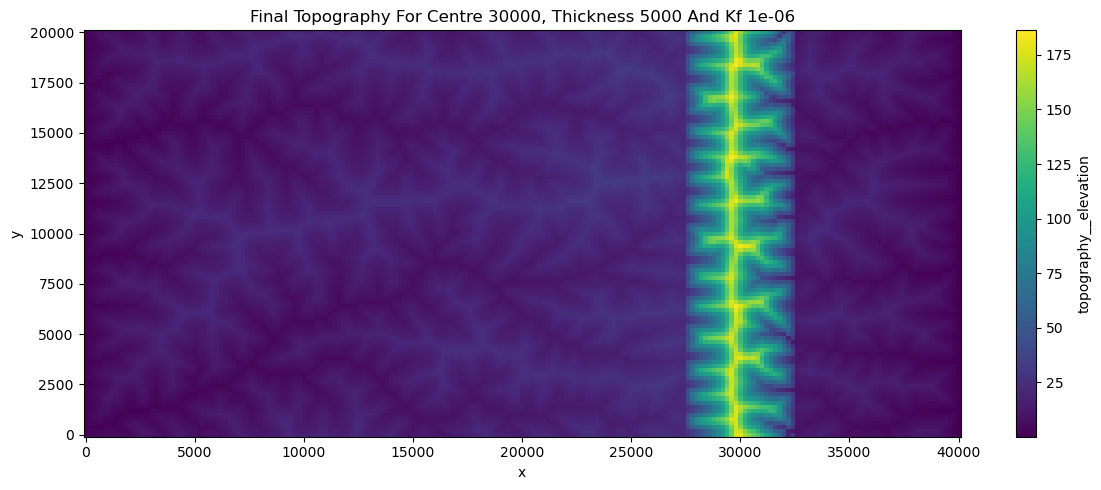

In [36]:
_ = plot_sim_result(EXP1_field_dict, path=p, centre=30000, thickness=5000, kf_n=0, noise=0, visualize=True)

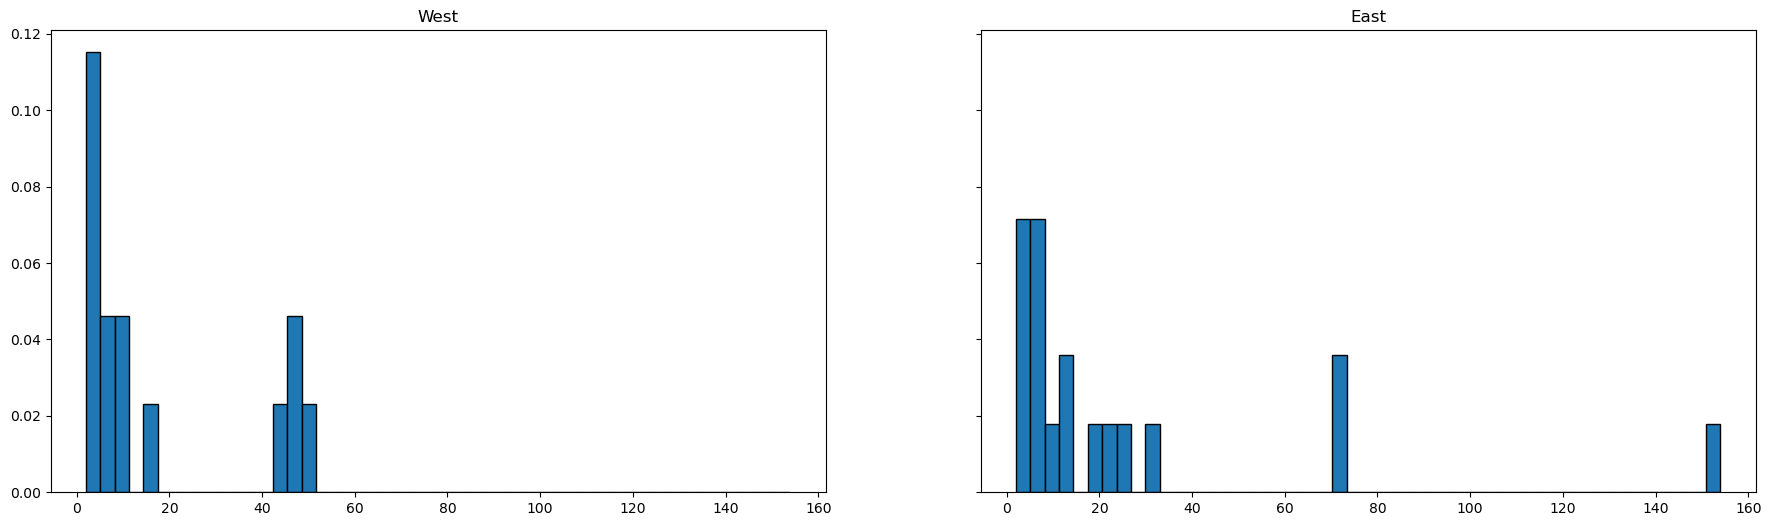

In [29]:
_ = metric_analysis(SIM=SIM_Sed_01_t, metric='diameter', node_based=False, visualize=True, log=False, bin_num=50)

In [90]:
def run_model_parallel(model, ds_in, x, y, noise):
    with model.drop_processes('init_topography'):
        ds_out =  ds_in.xsimlab.update_vars(
            input_vars={
                'topography__elevation': 
                    #xr.where(
                    #    x < x.max() / 2,
                    #    x / (x.max() / 2) * 10,
                    #    (x.max() - x) / (x.max() / 2) * 10) + 
                    noise,
                'spl__k_coef_bedrock' : kf_new
                    #(
                    #    xr.where(
                    #        (x < (x.max() / 2 + x.max() * 0.01)), # & (x > (x.max() / 2 - x.max() * 0.01))
                    #        5e-6 / 2, 5e-6
                    #    )
                    #)
                    ,
            }
        ).xsimlab.run()

    return ds_out

results_norm_sed_1 = Parallel(n_jobs=2)(delayed(run_model_parallel)(model_sed, ds_in_sed, x, y, noise=n) for n in noises)
len(results_norm_sed_1)

1

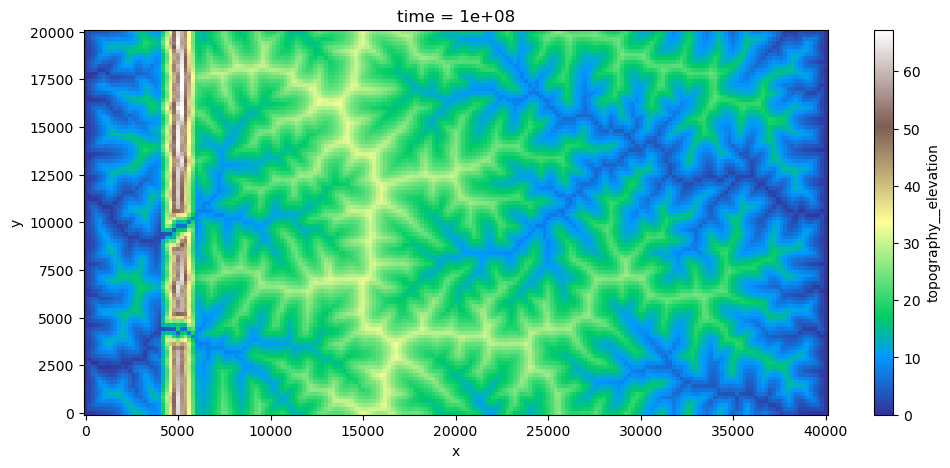

In [294]:
results_norm_sed_1[0].topography__elevation.isel(time=-1).plot(figsize=(12, 5), cmap="terrain", vmin=0)

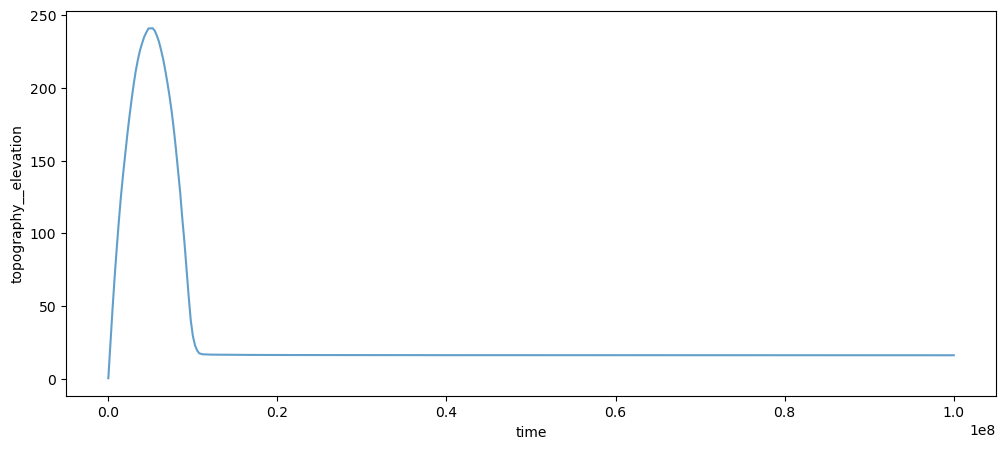

In [295]:
plt.figure(figsize=(12,5))
[run.topography__elevation.mean(("x", "y")).plot(alpha=0.7) for run in results_norm_sed_1]
plt.show()

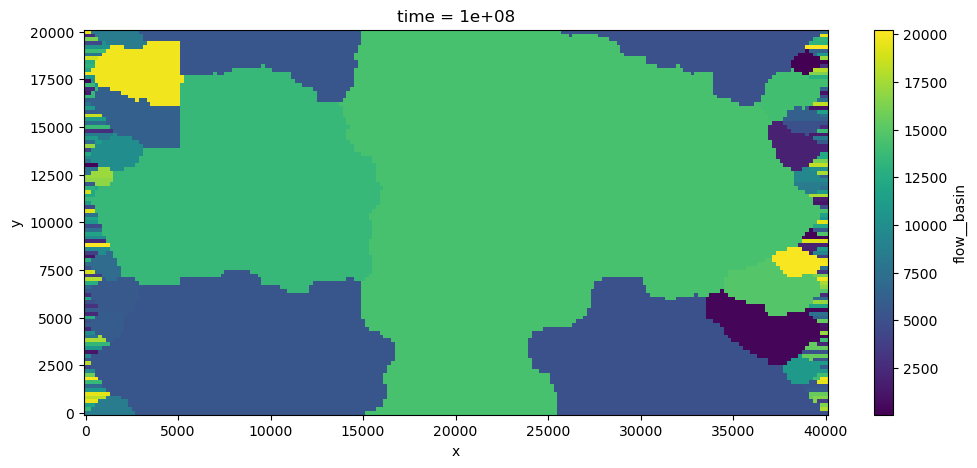

In [296]:
results_norm_sed_1[0].flow__basin.isel(time=-1).plot(figsize=(12, 5))

In [297]:
results_norm_sed_1[0].x.attrs["units"]= "m"
results_norm_sed_1[0].y.attrs["units"]= "m"
results_norm_sed_1[0].time.attrs["units"]= "years"

results_norm_sed_1[0].topography__elevation.to_netcdf('Topo.nc')

In [ ]:
SIM_Sed_01 = SIM_Bundler(results_list=results_norm_sed_1)
SIM_Sed_01.fastscape2graphs(parallel=True)
print(asizeof.asizeof(SIM_Sed_01) / (1024 ** 3))

c:\Users\malte\miniforge3\envs\fastscape_ESPM_2025\lib\site-packages\networkx\linalg\laplacianmatrix.py:432: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  evals, evecs = sp.sparse.linalg.eigs(P.T, k=1)


0.36705049127340317


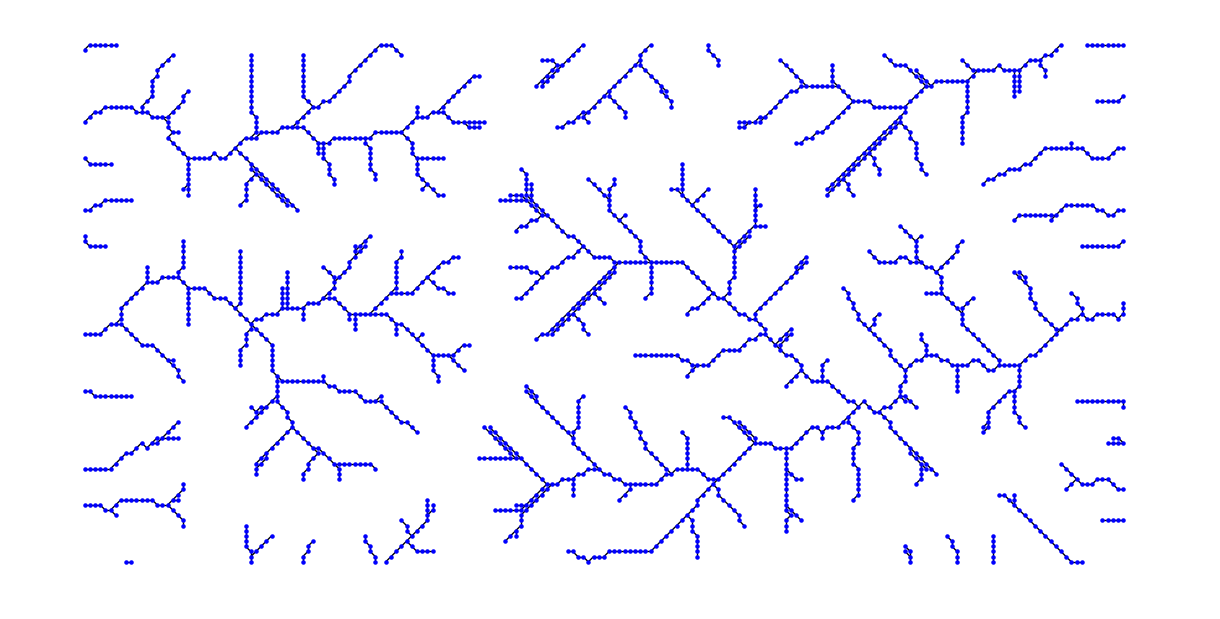

In [299]:
plt.figure(figsize=(12, 6))

for _, G in SIM_Sed_01.runs[0]["graphs"].items():
    pos = {n: n for n in G.nodes}
    netx.draw(G, pos=pos, node_size=5, node_color="blue", arrows=False)

plt.show()

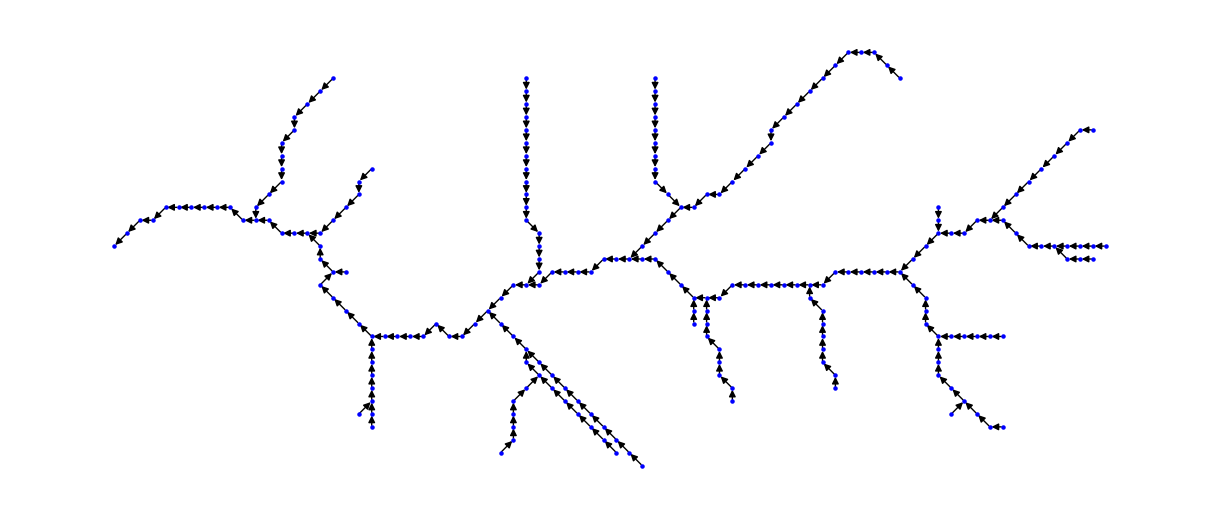

In [300]:
G = SIM_Sed_01.runs[0]["graphs"][2]

plt.figure(figsize=(12, 5))
pos = {n: n for n in G.nodes}
netx.draw(G, pos=pos, node_size=5, node_color="blue", arrows=True)
plt.show()

In [301]:
metrics = {}

metrics["g_metrics"] = {
    'diameter' : {},
    'avg_path_len' : {},
    'longest_path' : {},
    'num_nodes' : {},
    'num_edges' : {},
    'num_sources' : {},
    'num_sinks' : {},
    'radius' : {},
    'laplacian_spectrum' : {},
    'adjecency_spectrum' : {},
    'algebraic_connectivity': {},
    'num_connected_components': {},
    'spectral_radius': {},
    'spectral_energy': {},
    'spectral_gap': {},
}
metrics["n_metrics"] = {
    'degree' : {},
    'degree_centrality': {},
    'betweenness_centrality' : {},
    'closeness_centrality' : {},
    'pagerank' : {},
    'eigenvector' : {},
    'eccentricity' : {},
    'katz_centrality' : {},
    'laplacian_centrality' : {},
}

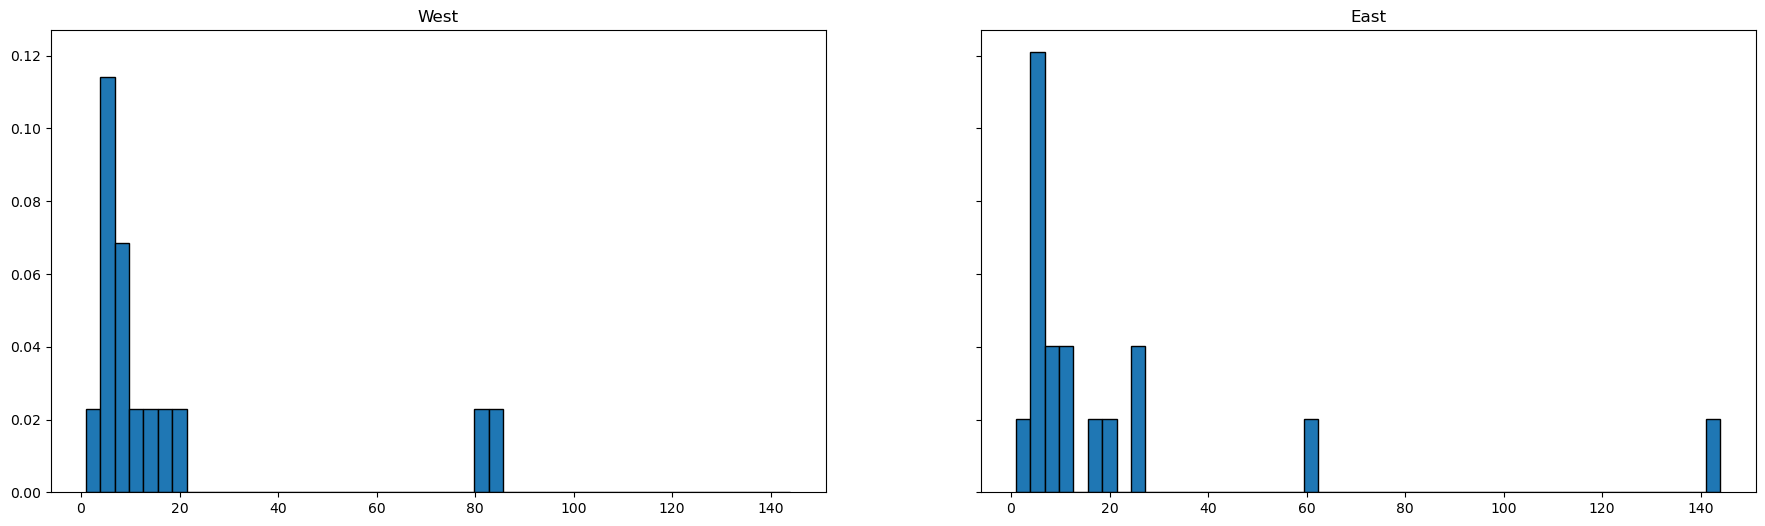

In [302]:
_ = metric_analysis(SIM=SIM_Sed_01, metric='diameter', node_based=False, visualize=True, log=False, bin_num=50)

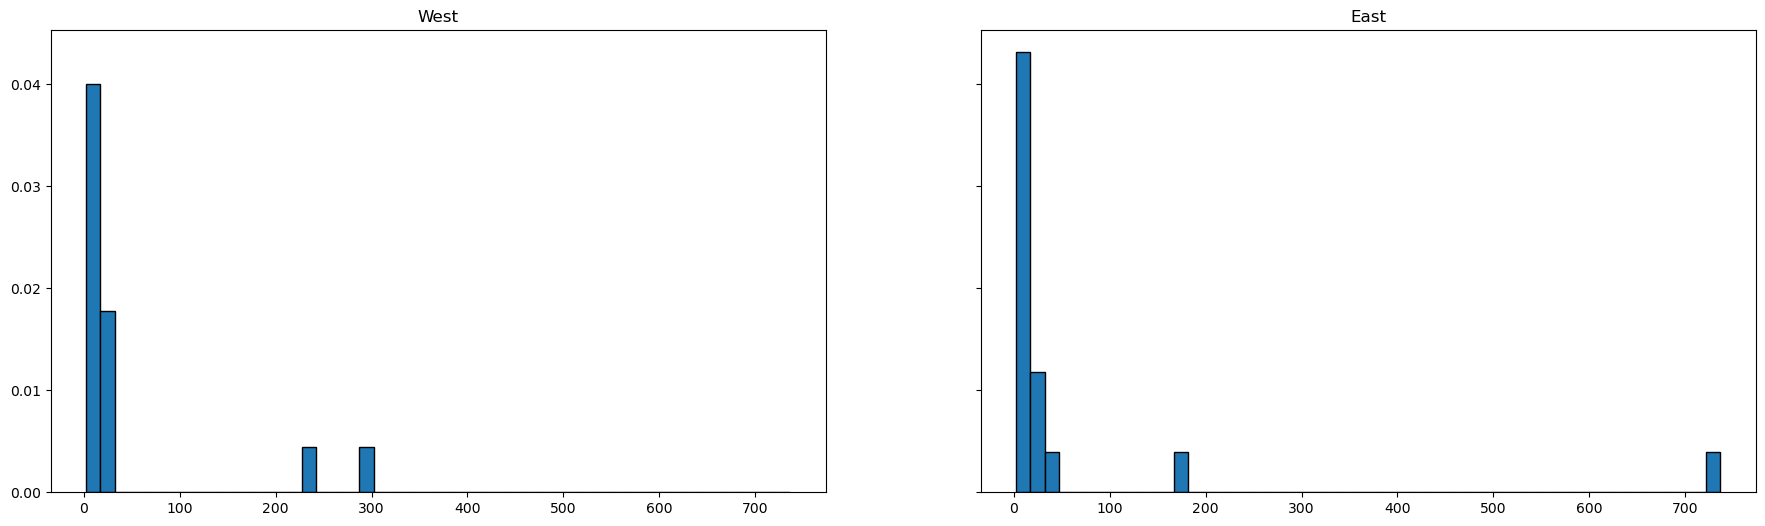

In [303]:
_ = metric_analysis(SIM=SIM_Sed_01, metric='num_nodes', node_based=False, visualize=True, log=False, bin_num=50)

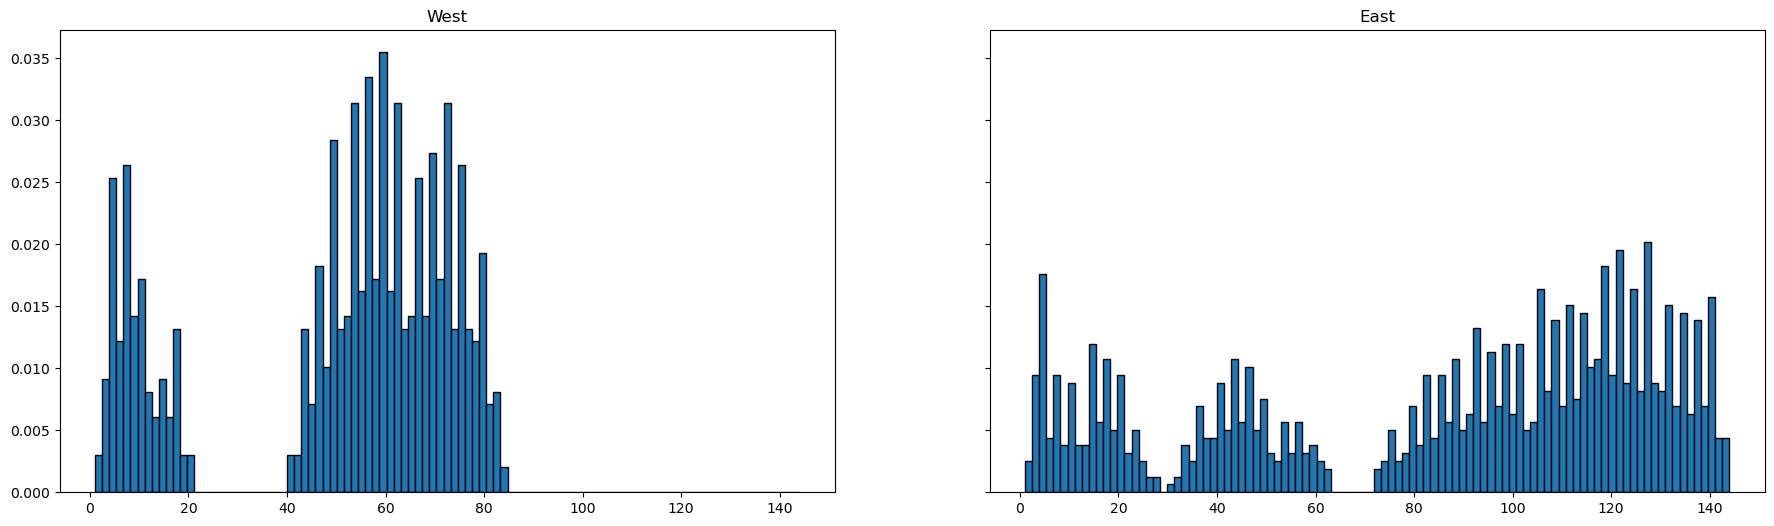

In [304]:
_ = metric_analysis(SIM=SIM_Sed_01, metric='eccentricity', node_based=True, visualize=True, log=False)

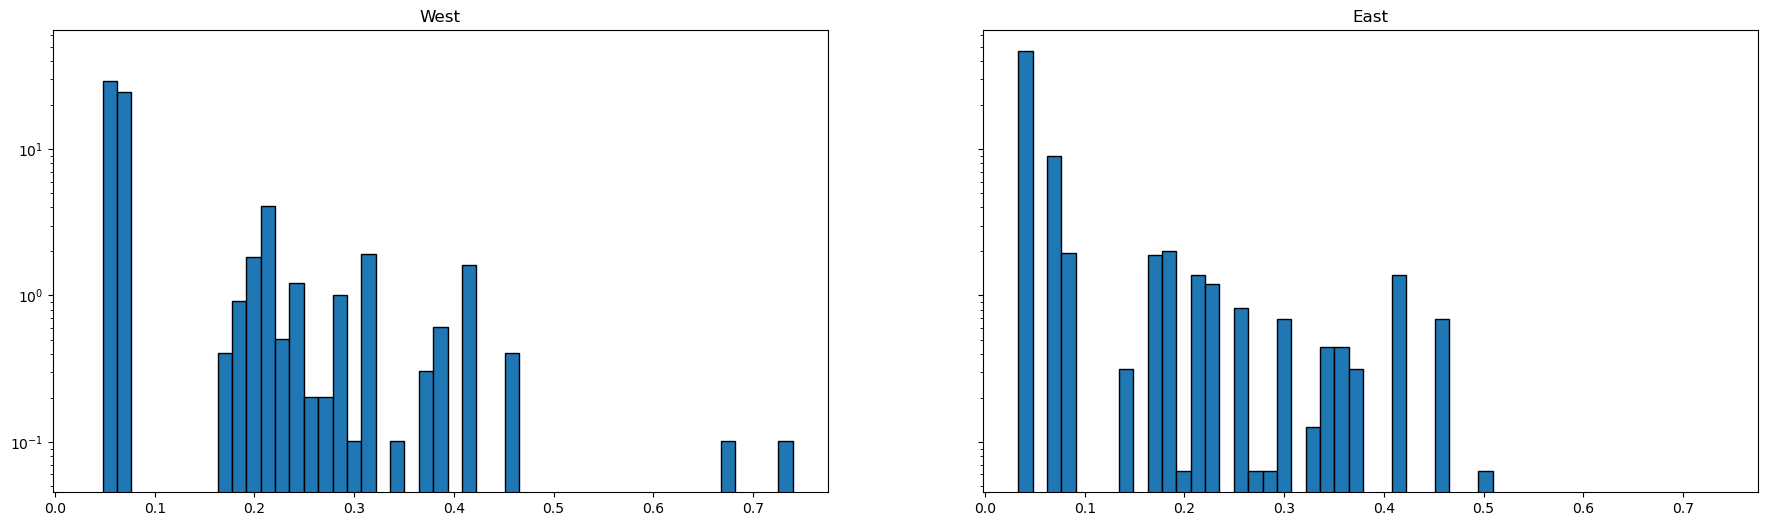

In [305]:
_ = metric_analysis(SIM=SIM_Sed_01, metric='katz_centrality', node_based=True, visualize=True, log=True, bin_num=50)

## Second Version

In [ ]:
def run_model_parallel(model, ds_in, x, y, noise):
    with model.drop_processes('init_topography'):
        ds_out =  ds_in.xsimlab.update_vars(
            input_vars={
                'topography__elevation': xr.where(
                        x < x.max() / 2,
                        x / (x.max() / 2) * 10,
                        (x.max() - x) / (x.max() / 2) * 10) + noise,
                'spl__k_coef_bedrock' : 
                        xr.where(
                            (x < (x.max() / 2 + x.max() * 0.01)), # & (x > (x.max() / 2 - x.max() * 0.01))
                            5e-6 * 2, 5e-6
                        )
            }
        ).xsimlab.run()

    return ds_out

In [ ]:
results_norm_sed_2 = Parallel(n_jobs=-4)(delayed(run_model_parallel)(model_sed, ds_in_sed, x, y, noise=n) for n in noises)
len(results_norm_sed_2)

1

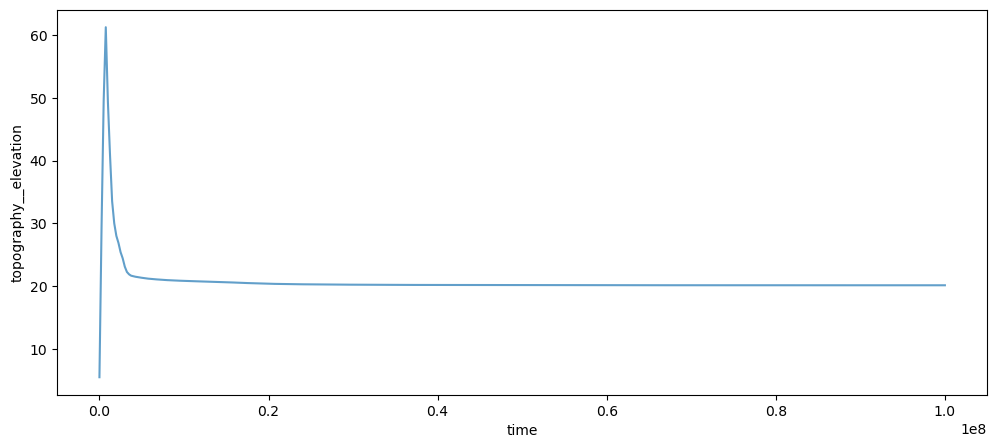

In [ ]:
plt.figure(figsize=(12,5))
[run.topography__elevation.mean(("x", "y")).plot(alpha=0.7) for run in results_norm_sed_2]
plt.show()

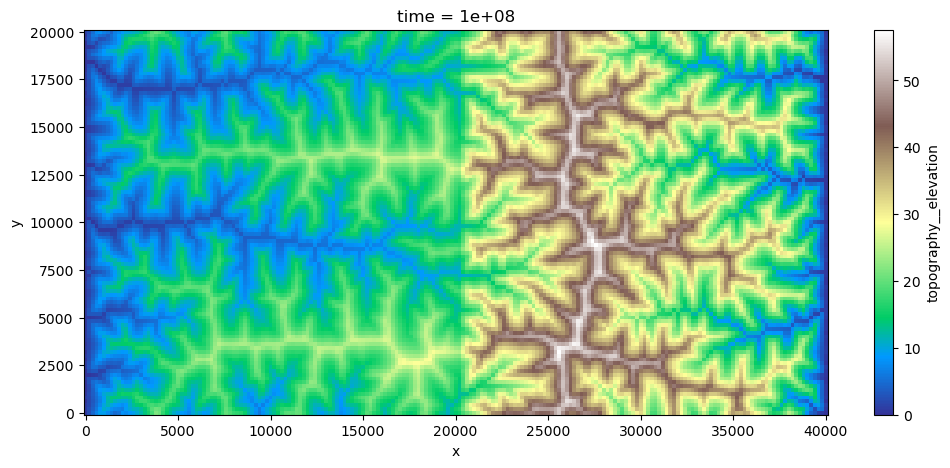

In [ ]:
results_norm_sed_2[0].topography__elevation.isel(time=-1).plot(figsize=(12, 5), cmap="terrain", vmin=0)

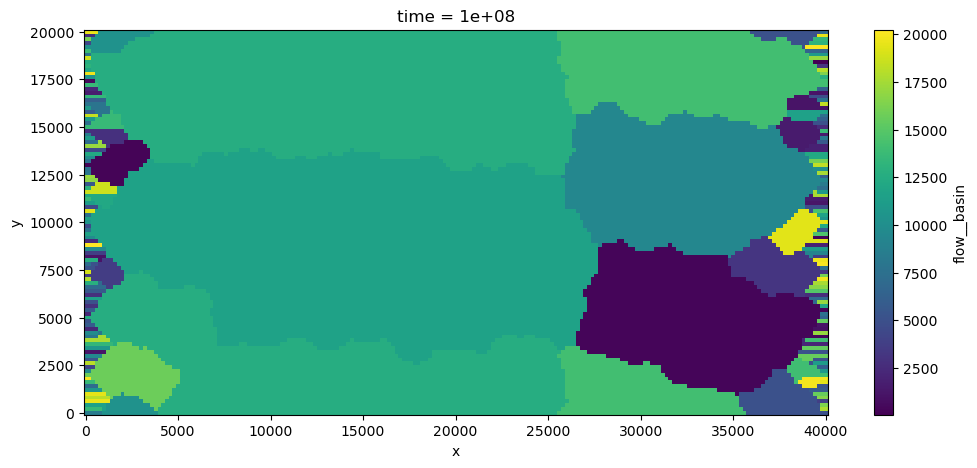

In [ ]:
results_norm_sed_2[0].flow__basin.isel(time=-1).plot(figsize=(12, 5))

In [ ]:
SIM_Sed_02 = SIM_Bundler(results_list=results_norm_sed_2)
SIM_Sed_02.fastscape2graphs(parallel=True)
print(asizeof.asizeof(SIM_Sed_02) / (1024 ** 3))

c:\Users\malte\miniforge3\envs\fastscape_ESPM_2025\lib\site-packages\networkx\linalg\laplacianmatrix.py:432: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  evals, evecs = sp.sparse.linalg.eigs(P.T, k=1)


0.3680591359734535


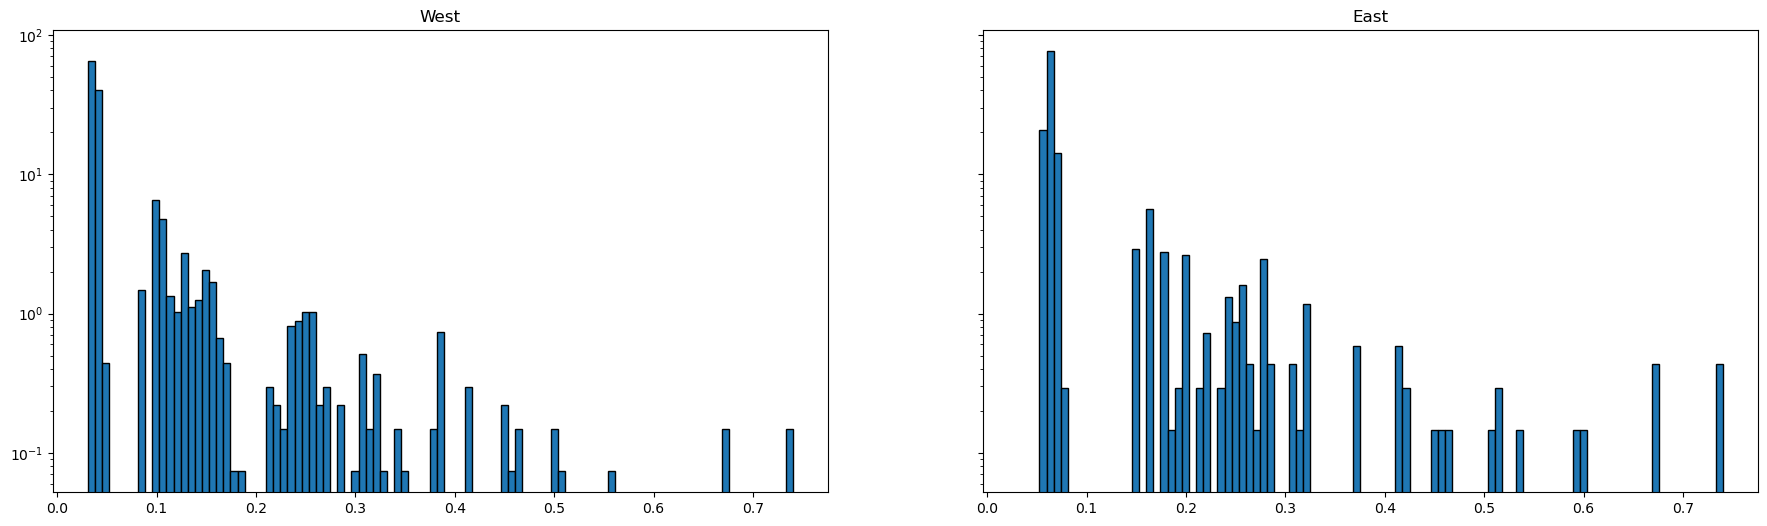

In [ ]:
_ = metric_analysis(SIM=SIM_Sed_02, metric='katz_centrality', node_based=True, visualize=True, log=True)

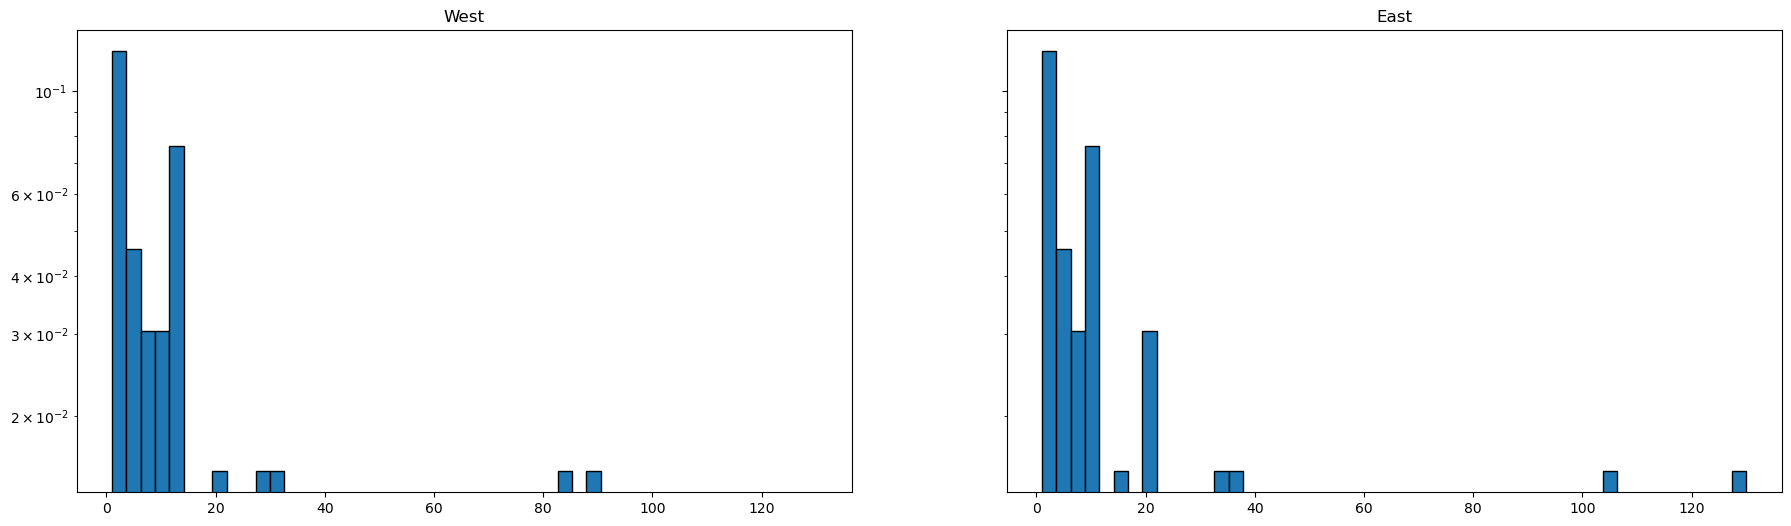

In [ ]:
_ = metric_analysis(SIM=SIM_Sed_01, metric="diameter", node_based=False, visualize=True, log=True, bin_num=50)

# Precipitation Tests

In [36]:
ds_in_prec = xs.create_setup(
    model=precip_model,
    clocks={'tstep':tstep, 'time':time},
    master_clock='tstep',
    input_vars={
        'grid__shape': [ny,nx],
        'grid__length': [yl,xl],
        'boundary__status': ['fixed_value','fixed_value','looped','looped'],
        'uplift__rate': 1e-4,
        'init_topography__seed': None,
        'diffusion__diffusivity': 0.1,
        'spl__k_coef': 1e-5,
        'spl__area_exp': 0.45,
        'spl__slope_exp': 1,
        'orographic':{'rainfall_frequency':1, 
                         'latitude': 40, 
                         'precip_base': precip_base_xr,        
                         'wind_speed': 10,          
                         'wind_dir': 270,
         }
    },
    output_vars={
        'topography__elevation': 'time',
        'orographic__precip_rate':'time',
        'flow__basin': 'time',
    }
)

In [37]:
x,y = np.meshgrid(np.linspace(0, ds_in_prec.grid__length[1], ds_in_prec.grid__shape[1].values),
                  np.linspace(0, ds_in_prec.grid__length[0], ds_in_prec.grid__shape[0].values))

x = xr.DataArray(x, dims=('y', 'x'))
y = xr.DataArray(y, dims=('y', 'x'))

In [38]:
def run_model_parallel(model, ds_in, x, y, noise):
    with model.drop_processes('init_topography'):
        ds_out =  ds_in.xsimlab.update_vars(
            input_vars={
                'topography__elevation': xr.where(
                        x < x.max() / 2,
                        x / (x.max() / 2) * 0,
                        (x.max() - x) / (x.max() / 2) * 0) + noise,
            }
        ).xsimlab.run()

    return ds_out

results_norm_prec_01 = Parallel(n_jobs=-4)(delayed(run_model_parallel)(precip_model, ds_in_prec, x, y, noise=n) for n in noises)
len(results_norm_prec_01)

1

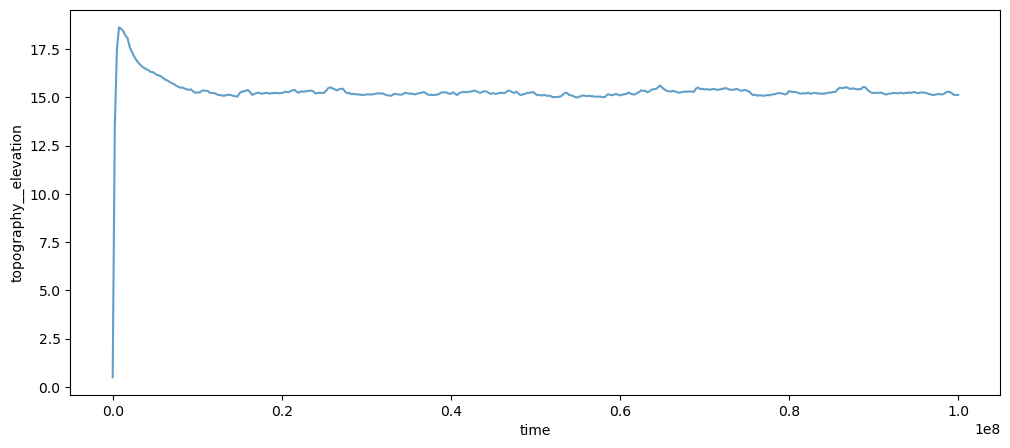

In [39]:
plt.figure(figsize=(12,5))
[run.topography__elevation.mean(("x", "y")).plot(alpha=0.7) for run in results_norm_prec_01]
plt.show()

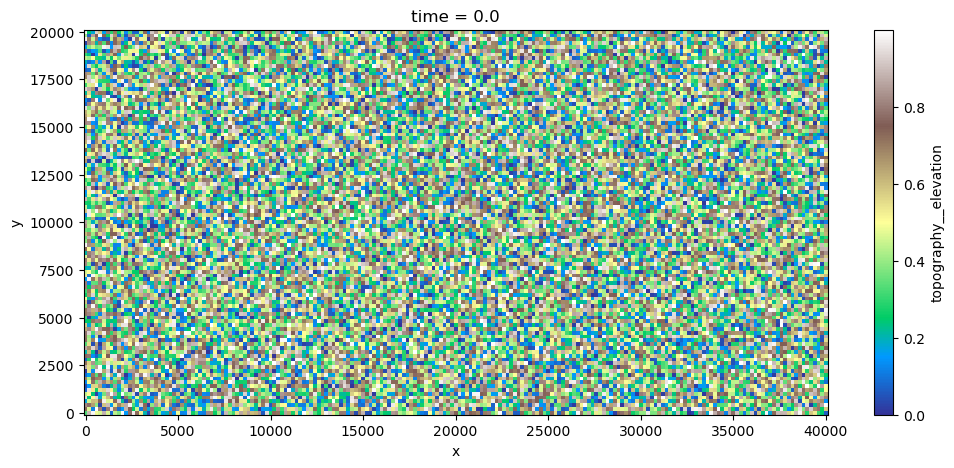

In [40]:
results_norm_prec_01[0].topography__elevation.isel(time=0).plot(figsize=(12, 5), cmap="terrain", vmin=0)

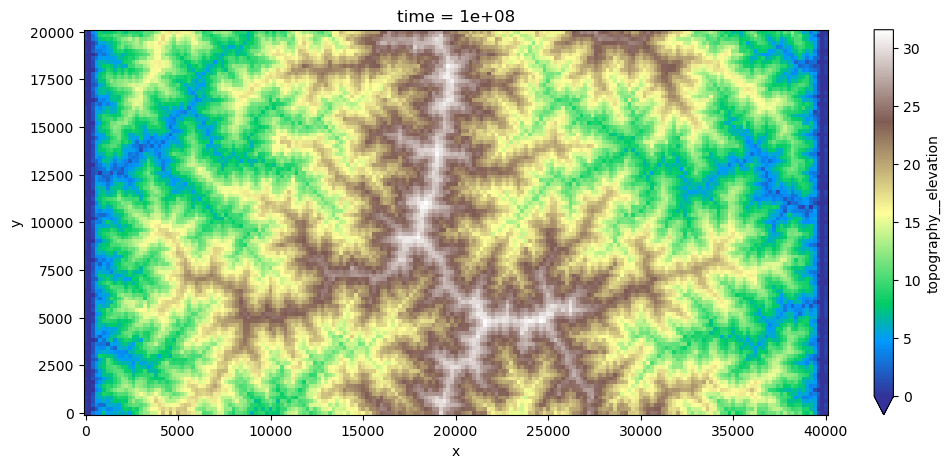

In [41]:
results_norm_prec_01[0].topography__elevation.isel(time=-1).plot(figsize=(12, 5), cmap="terrain", vmin=0)

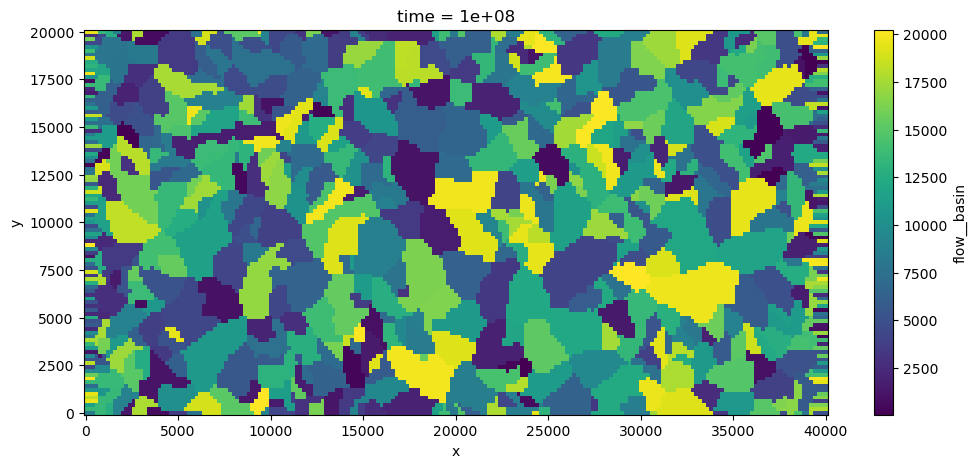

In [42]:
results_norm_prec_01[0].flow__basin.isel(time=-1).plot(figsize=(12, 5))

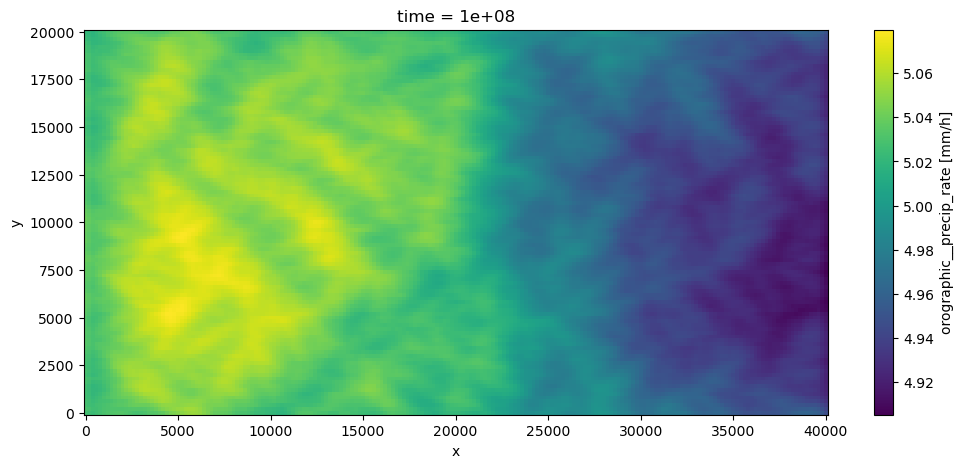

In [43]:
results_norm_prec_01[0].orographic__precip_rate.isel(time=-1).plot(figsize=(12, 5))

In [ ]:
SIM_Prec_01 = SIM_Bundler(results_list=results_norm_prec_01)
SIM_Prec_01.fastscape2graphs(parallel=True)
print(asizeof.asizeof(SIM_Prec_01) / (1024 ** 3))

c:\Users\malte\miniforge3\envs\fastscape_ESPM_2025\lib\site-packages\networkx\linalg\laplacianmatrix.py:432: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  evals, evecs = sp.sparse.linalg.eigs(P.T, k=1)


0.3676527291536331


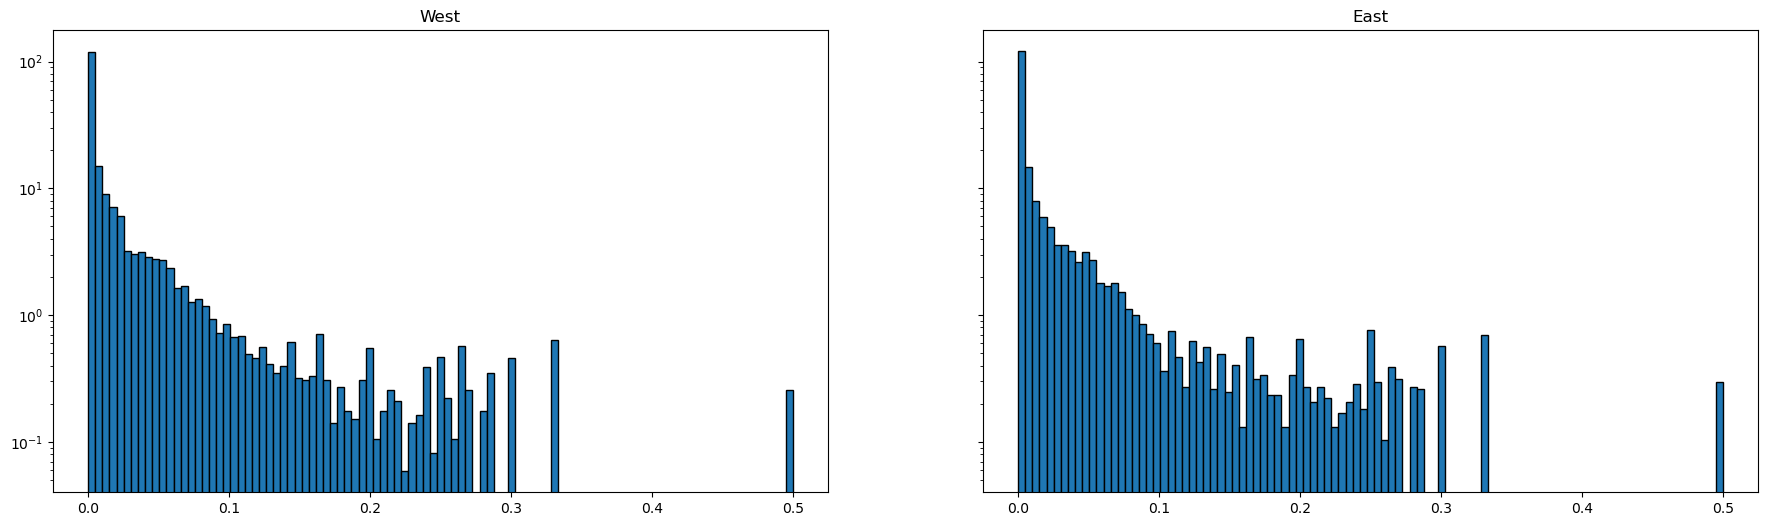

In [ ]:
_ = metric_analysis(SIM=SIM_Prec_01, metric='betweenness', node_based=True, visualize=True, log=True)

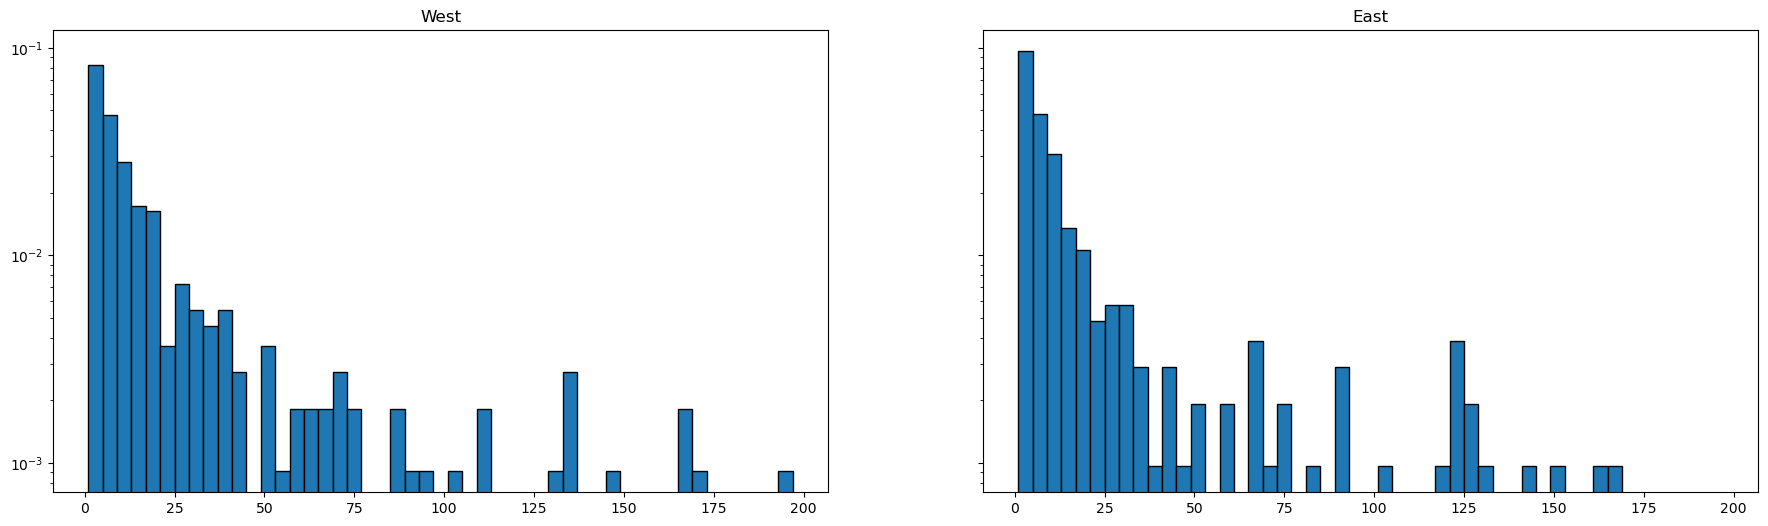

In [ ]:
_ = metric_analysis(SIM=SIM_Prec_01, metric="diameter", node_based=False, visualize=True, log=True, bin_num=50)

### Low Uplift

In [ ]:
def run_model_parallel(model, ds_in, x, y, noise):
    with model.drop_processes('init_topography'):
        ds_out =  ds_in.xsimlab.update_vars(
            input_vars={
                'topography__elevation': xr.where(
                        x < x.max() / 2,
                        x / (x.max() / 2) * 1,
                        (x.max() - x) / (x.max() / 2) * 1) + noise,
                'uplift__rate' : 1e-5,
            }
        ).xsimlab.run()

    return ds_out

results_norm_prec_02 = Parallel(n_jobs=-4)(delayed(run_model_parallel)(precip_model, ds_in_prec, x, y, noise=n) for n in noises)
len(results_norm_prec_02)

10

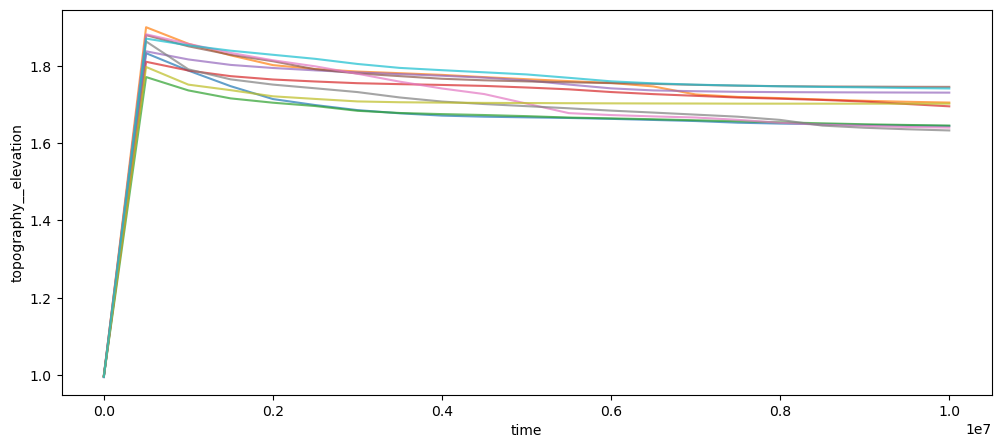

In [ ]:
plt.figure(figsize=(12,5))
[run.topography__elevation.mean(("x", "y")).plot(alpha=0.7) for run in results_norm_prec_02]
plt.show()

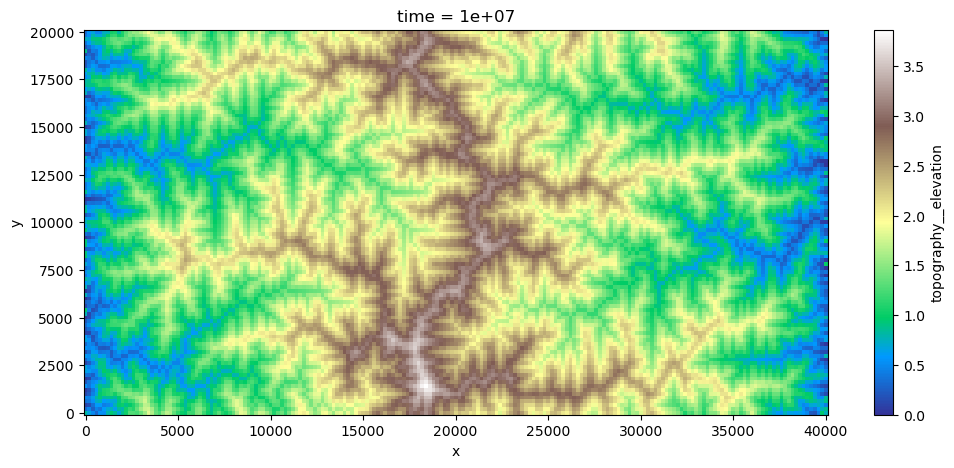

In [ ]:
results_norm_prec_02[0].topography__elevation.isel(time=-1).plot(figsize=(12, 5), cmap="terrain", vmin=0)

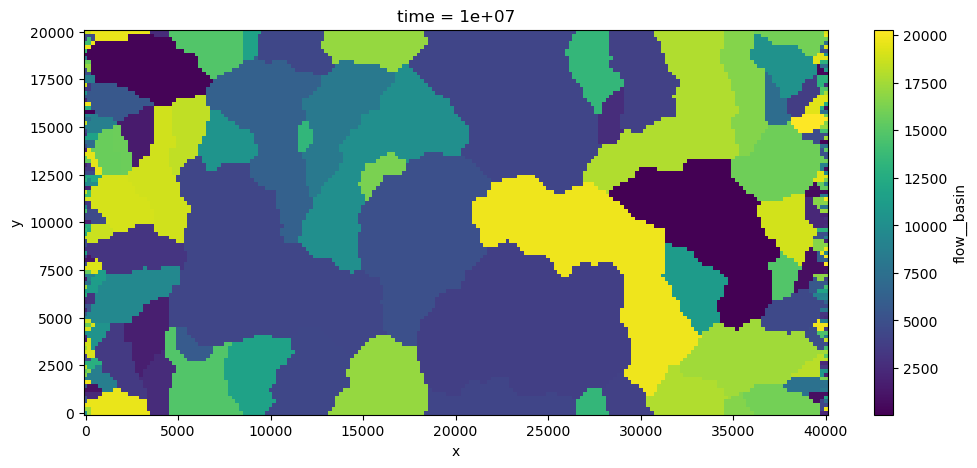

In [ ]:
results_norm_prec_02[0].flow__basin.isel(time=-1).plot(figsize=(12, 5))

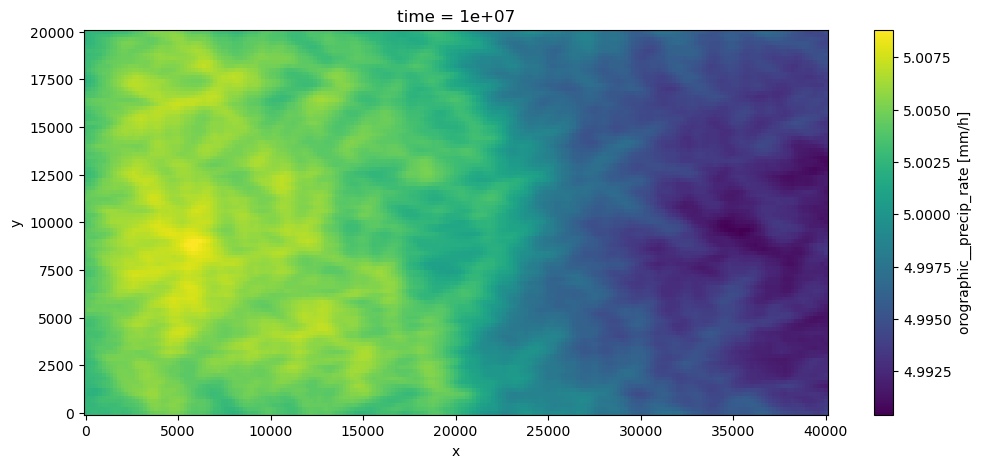

In [ ]:
results_norm_prec_02[0].orographic__precip_rate.isel(time=-1).plot(figsize=(12, 5))

In [ ]:
SIM_Prec_02 = SIM_Bundler(results_list=results_norm_prec_02)
SIM_Prec_02.fastscape2graphs(parallel=True)
print(asizeof.asizeof(SIM_Prec_02) / (1024 ** 3))

0.23212414979934692


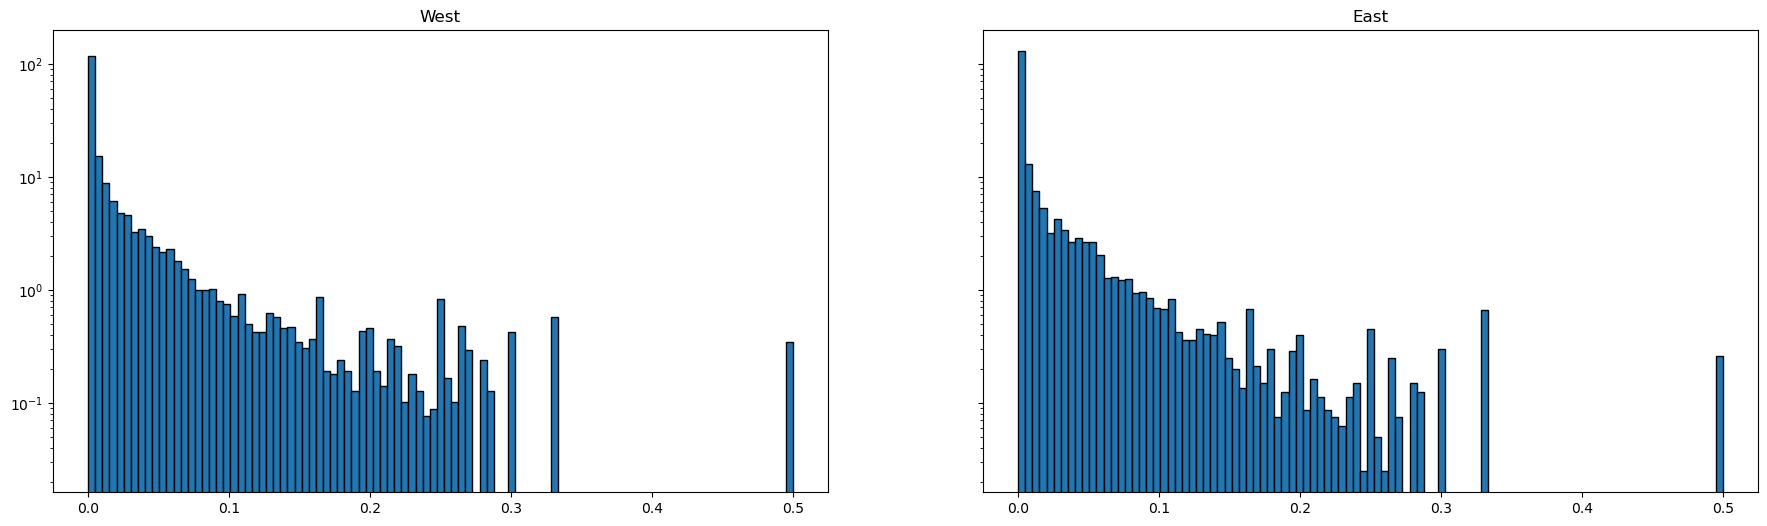

In [ ]:
_ = metric_analysis(SIM=SIM_Prec_02, metric='betweenness', node_based=True, visualize=True, log=True)

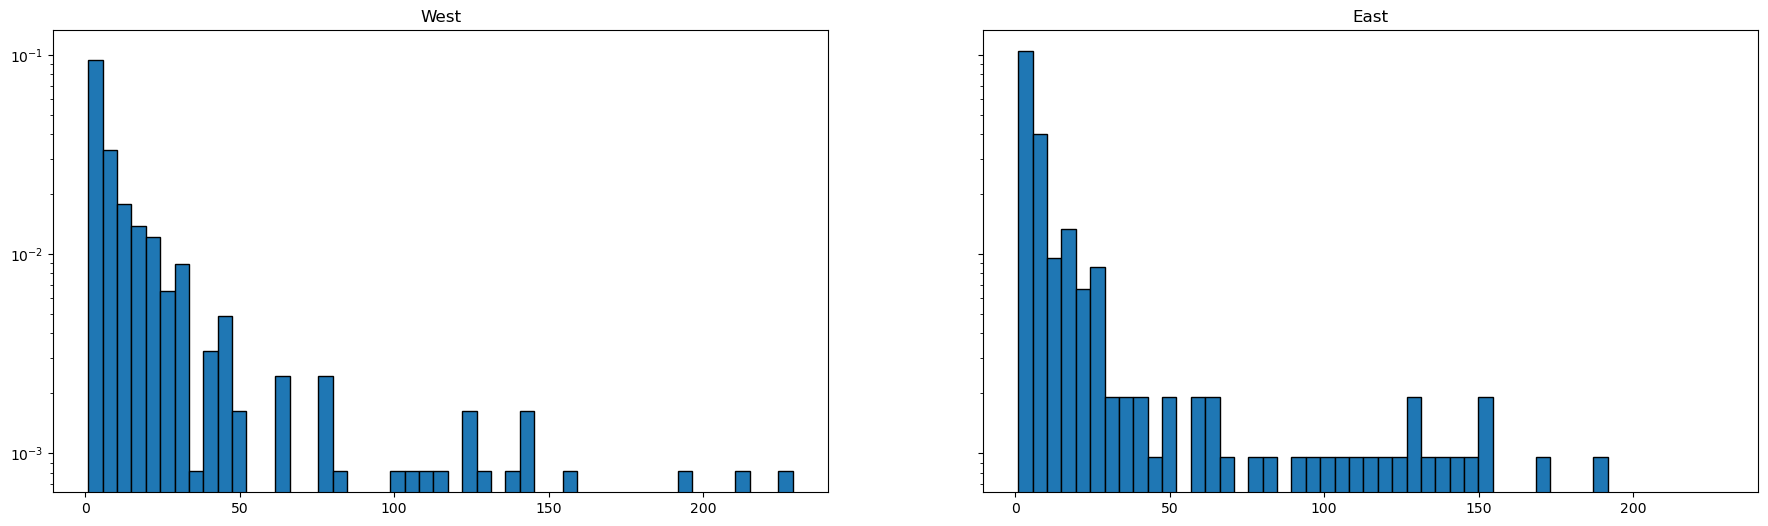

In [ ]:
_ = metric_analysis(SIM=SIM_Prec_02, metric="diameter", node_based=False, visualize=True, log=True, bin_num=50)

### High Uplift

In [ ]:
def run_model_parallel(model, ds_in, x, y, noise):
    with model.drop_processes('init_topography'):
        ds_out =  ds_in.xsimlab.update_vars(
            input_vars={
                'topography__elevation': xr.where(
                        x < x.max() / 2,
                        x / (x.max() / 2) * 1,
                        (x.max() - x) / (x.max() / 2) * 1) + noise,
                'uplift__rate' : 1e-3,
            }
        ).xsimlab.run()

    return ds_out

results_norm_prec_03 = Parallel(n_jobs=-4)(delayed(run_model_parallel)(precip_model, ds_in_prec, x, y, noise=n) for n in noises)
len(results_norm_prec_03)

10

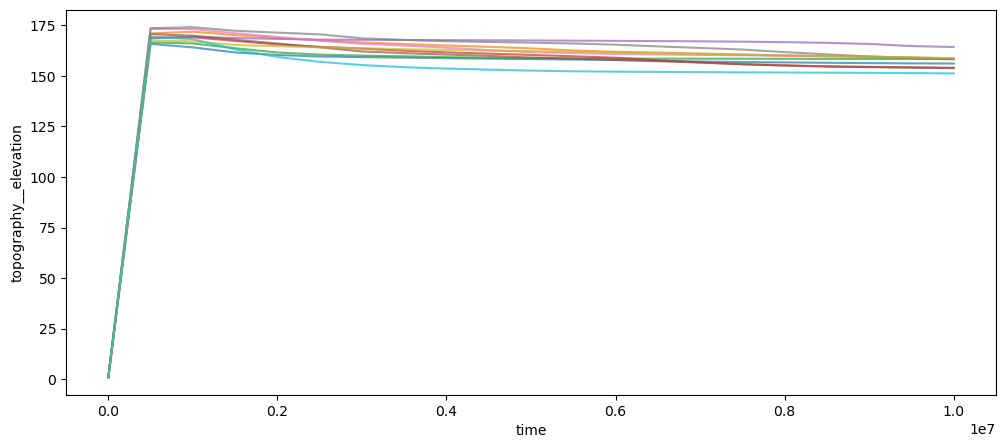

In [ ]:
plt.figure(figsize=(12,5))
[run.topography__elevation.mean(("x", "y")).plot(alpha=0.7) for run in results_norm_prec_03]
plt.show()

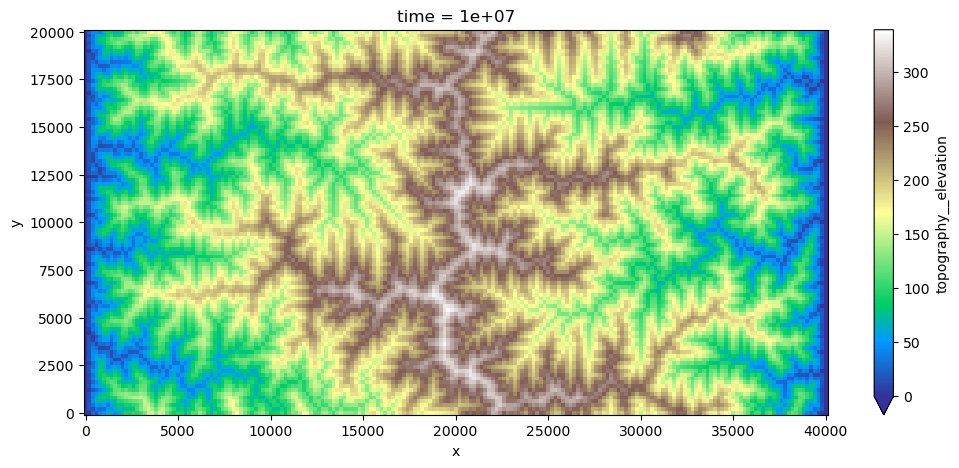

In [ ]:
results_norm_prec_03[0].topography__elevation.isel(time=-1).plot(figsize=(12, 5), cmap="terrain", vmin=0)

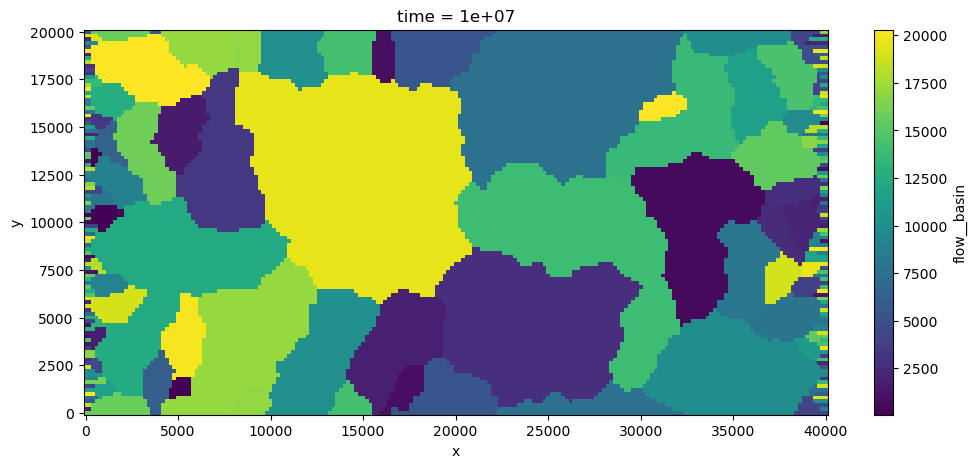

In [ ]:
results_norm_prec_03[0].flow__basin.isel(time=-1).plot(figsize=(12, 5))

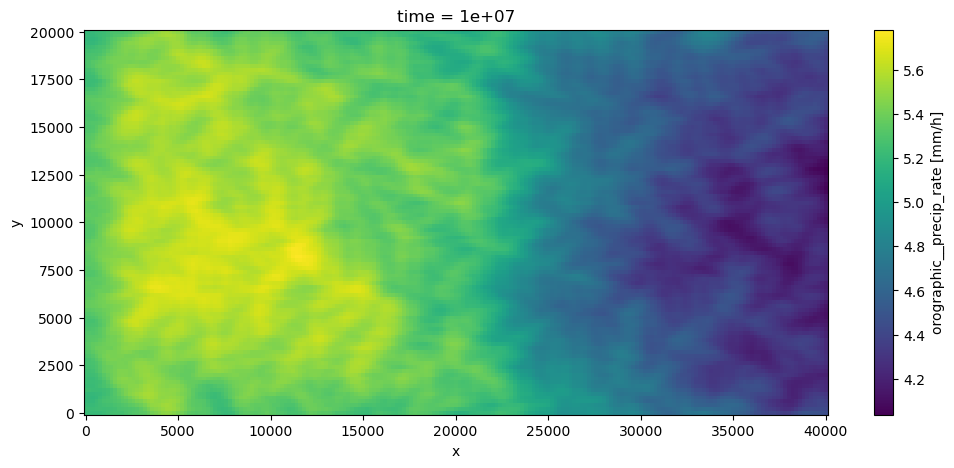

In [ ]:
results_norm_prec_03[0].orographic__precip_rate.isel(time=-1).plot(figsize=(12, 5))

In [ ]:
SIM_Prec_03 = SIM_Bundler(results_list=results_norm_prec_03)
SIM_Prec_03.fastscape2graphs(parallel=True)
print(asizeof.asizeof(SIM_Prec_03) / (1024 ** 3))

0.23261525481939316


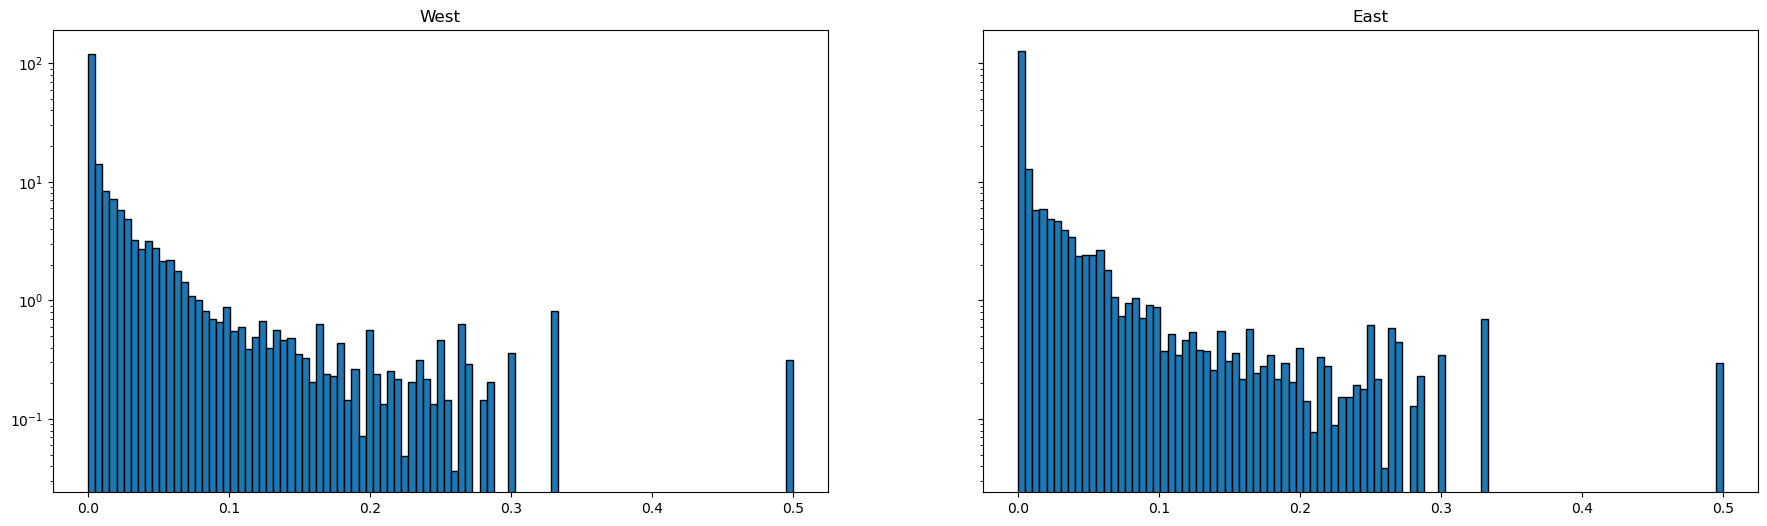

In [ ]:
_ = metric_analysis(SIM=SIM_Prec_03, metric='betweenness', node_based=True, visualize=True, log=True)

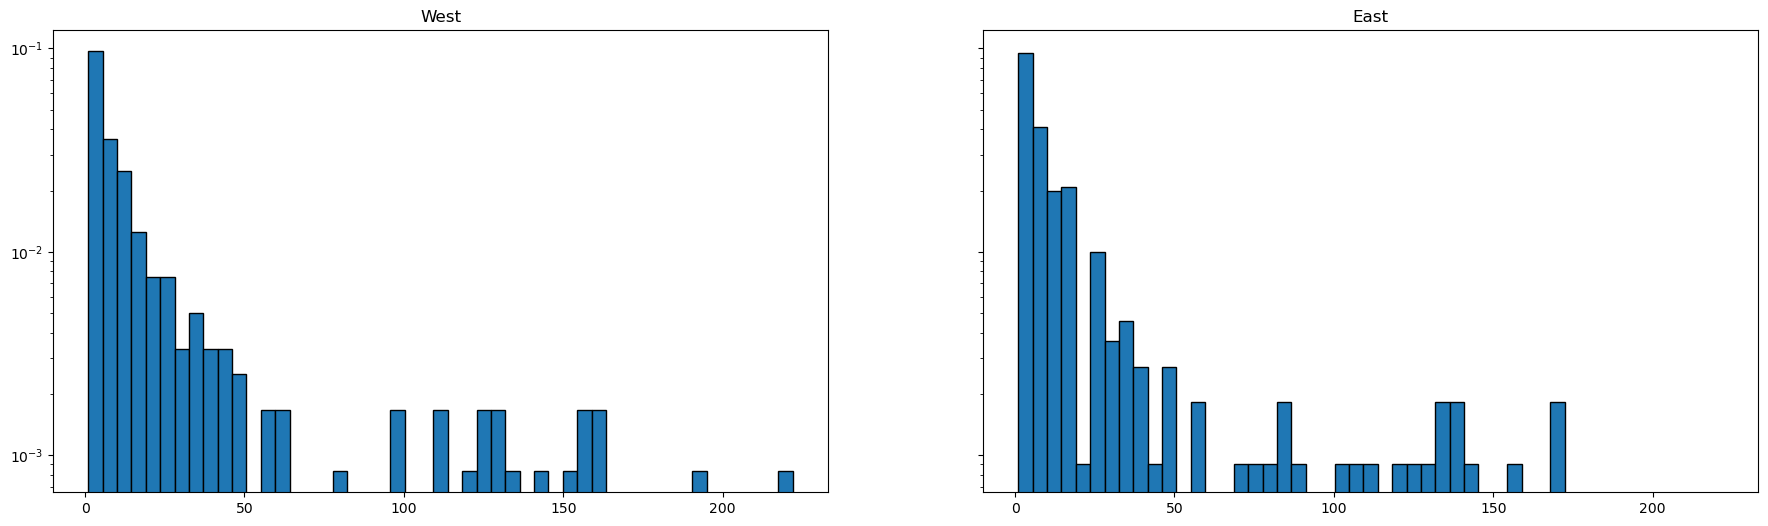

In [ ]:
_ = metric_analysis(SIM=SIM_Prec_03, metric="diameter", node_based=False, visualize=True, log=True, bin_num=50)